In [1]:
import pandas as pd
import plotly.graph_objs as go
import plotly.subplots as sp
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
yields = pd.read_csv('/Users/evelynli/Documents/Work/ASL/ETF Hedging Data/ETF/processed data/daily-treasury-rates.csv', index_col= 'Date', parse_dates= True)
yields.dropna(inplace= True)
yields

1     3     6    12    24    36    60    84   120   240   360
Date                                                                        
2006-02-09  4.32  4.52  4.67  4.66  4.66  4.62  4.55  4.55  4.54  4.72  4.51
2006-02-10  4.36  4.53  4.70  4.70  4.69  4.67  4.59  4.59  4.59  4.76  4.55
2006-02-13  4.38  4.55  4.71  4.70  4.68  4.66  4.58  4.58  4.58  4.76  4.56
2006-02-14  4.42  4.55  4.72  4.71  4.69  4.68  4.61  4.61  4.62  4.80  4.60
2006-02-15  4.39  4.55  4.70  4.70  4.71  4.68  4.60  4.60  4.61  4.78  4.58
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
2024-08-06  5.50  5.34  5.00  4.46  3.99  3.76  3.73  3.79  3.90  4.28  4.18
2024-08-07  5.50  5.34  4.99  4.45  4.00  3.81  3.79  3.85  3.96  4.35  4.26
2024-08-08  5.55  5.34  5.01  4.48  4.04  3.86  3.83  3.89  3.99  4.38  4.28
2024-08-09  5.54  5.33  5.02  4.50  4.05  3.86  3.80  3.85  3.94  4.33  4.23
2024-08-12  5.53  5.33  5.02  4.47  4.01  3.82  3.75  3.80  3.90  4.30  4.19

[4629 rows x 11 columns]

In [17]:
fig = sp.make_subplots(
    rows=6, cols=2, subplot_titles=yields.columns[1:], 
    shared_xaxes=False, shared_yaxes=False,
    vertical_spacing=0.05, horizontal_spacing=0.1
)

# Adding traces for each maturity
row = 1
col = 1
for col_name in yields.columns[1:]:
    fig.add_trace(
        go.Scatter(x=yields.index, y=yields[col_name], mode='lines', name=col_name), 
        row=row, col=col
    )
    fig.update_xaxes(title_text="Date", row=row, col=col)
    fig.update_yaxes(title_text="Yield (%)", row=row, col=col)
    
    col += 1
    if col > 2:
        col = 1
        row += 1

# Updating the overall layout
fig.update_layout(
    height=1500, width=1200, title_text="Treasury Yield Changes Across Different Maturities",
    showlegend=False, template="plotly_white"
)

fig.show()


In [161]:
train_data = yields['2006-01-01':'2021-12-31']
test_data = yields['2021-01-01':'2024-08-12']
test_index = test_data.index
test_columns = test_data.columns
print(len(test_data))

904


In [133]:
from sklearn.preprocessing import MinMaxScaler

# 数据归一化处理
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# 定义滑动窗口函数
def create_dataset(data, time_step=5):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# 创建训练和测试集
time_step = 10
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)
len(y_test)


894

In [134]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# 定义LSTM模型
def create_lstm_model(input_shape):
    inputs = Input(shape=input_shape)  # 使用 Input(shape) 定义输入层
    x = LSTM(50, return_sequences=True)(inputs)
    x = LSTM(50, return_sequences=False)(x)
    outputs = Dense(train_data.shape[1])(x)  # 输出层，输出维度与特征数相同
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# 创建模型
model = create_lstm_model((X_train.shape[1], X_train.shape[2]))


In [135]:
# 训练模型
model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=2)


Epoch 1/50
100/100 - 1s - 12ms/step - loss: 0.0216 - val_loss: 0.0023
Epoch 2/50
100/100 - 0s - 3ms/step - loss: 8.6698e-04 - val_loss: 0.0012
Epoch 3/50
100/100 - 0s - 3ms/step - loss: 6.5338e-04 - val_loss: 8.4896e-04
Epoch 4/50
100/100 - 0s - 3ms/step - loss: 5.7760e-04 - val_loss: 7.5152e-04
Epoch 5/50
100/100 - 0s - 3ms/step - loss: 5.2971e-04 - val_loss: 7.2253e-04
Epoch 6/50
100/100 - 0s - 3ms/step - loss: 5.1239e-04 - val_loss: 9.6448e-04
Epoch 7/50
100/100 - 0s - 3ms/step - loss: 5.1034e-04 - val_loss: 7.1592e-04
Epoch 8/50
100/100 - 0s - 3ms/step - loss: 4.8841e-04 - val_loss: 7.6969e-04
Epoch 9/50
100/100 - 0s - 3ms/step - loss: 4.7040e-04 - val_loss: 7.1972e-04
Epoch 10/50
100/100 - 0s - 3ms/step - loss: 4.8047e-04 - val_loss: 6.9927e-04
Epoch 11/50
100/100 - 0s - 3ms/step - loss: 4.4604e-04 - val_loss: 6.4089e-04
Epoch 12/50
100/100 - 0s - 3ms/step - loss: 4.3639e-04 - val_loss: 7.2280e-04
Epoch 13/50
100/100 - 0s - 3ms/step - loss: 4.2751e-04 - val_loss: 6.5116e-04
Epoch 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


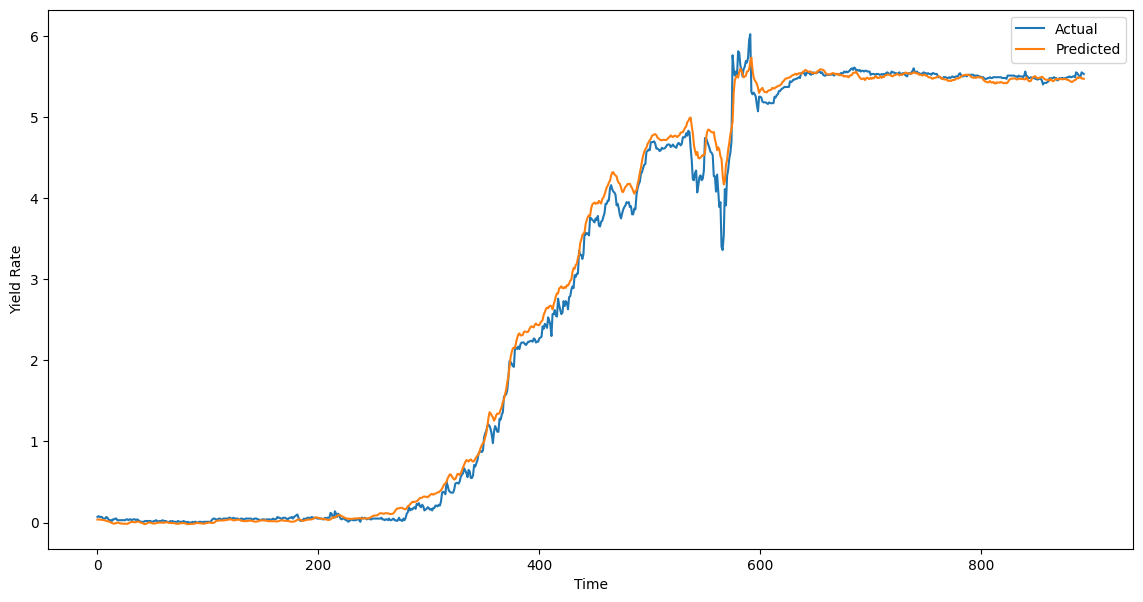

In [136]:
# 预测
predicted = model.predict(X_test)

# 反归一化
predicted_rescaled = scaler.inverse_transform(predicted)
y_test_rescaled = scaler.inverse_transform(y_test)

# 显示预测结果与实际结果
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled[:, 0], label='Actual')
plt.plot(predicted_rescaled[:, 0], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Yield Rate')
plt.legend()
plt.show()


In [137]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 计算误差指标
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Squared Error (MSE): 0.0006
Root Mean Squared Error (RMSE): 0.0249
Mean Absolute Error (MAE): 0.0187


In [138]:
import statsmodels.api as sm

def table4(predicted_yields, observed_yields):
    
    err = observed_yields.iloc[:, :] - predicted_yields.iloc[:, :]
    
    
    # Initialize the table DataFrame
    table = pd.DataFrame(np.zeros((11, 5)), 
                         index=observed_yields.columns, 
                         columns=['mean', 'std. dev.', 'RMSE', 'ACF(1)', 'ACF(12)'])
    
    # Fill the table with statistics for each maturity
    for idx in table.index:
        table.loc[idx, 'mean'] = err.loc[:, idx].mean()
        table.loc[idx, 'std. dev.'] = err.loc[:, idx].std()
        table.loc[idx, 'RMSE'] = np.sqrt(np.mean(err.loc[:, idx]**2))
        
        acf_values = sm.tsa.acf(err.loc[:, idx], nlags=13)
        table.loc[idx, 'ACF(1)'] = acf_values[1]
        table.loc[idx, 'ACF(12)'] = acf_values[12] if len(acf_values) > 12 else np.nan

    return table

In [139]:
predicted_yields = pd.DataFrame(predicted_rescaled, index=test_data.index[time_step:], columns=test_data.columns)
observed_yields = test_data.iloc[time_step:, :]

In [140]:
table4(predicted_yields, observed_yields)

mean  std. dev.      RMSE    ACF(1)   ACF(12)
1   -0.050230   0.129263  0.138612  0.819045  0.381870
3    0.003299   0.090926  0.090935  0.877257  0.599391
6   -0.019592   0.066561  0.069349  0.760078  0.301789
12   0.038937   0.092505  0.100318  0.750735  0.284472
24   0.007631   0.092311  0.092574  0.548112  0.096855
36  -0.040463   0.096969  0.105023  0.567837  0.136862
60  -0.113805   0.089123  0.144519  0.481913  0.105383
84  -0.081218   0.096984  0.126459  0.625831  0.257523
120 -0.139635   0.095752  0.169281  0.647525  0.365375
240 -0.069988   0.076803  0.103877  0.550621  0.133606
360 -0.134575   0.077448  0.155248  0.601943  0.133254

prediction under a rolling window

In [27]:
window_size = 10 * 252  # 5 years with 252 trading days per year
prediction_horizon = 1
diff_yields = yields.diff().iloc[1:]

train_data = diff_yields['2006-01-01':'2021-12-31']
test_data = diff_yields['2021-01-01':'2024-08-12']
test_index = test_data.index
test_columns = test_data.columns

In [21]:
test_index


DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2024-07-30', '2024-07-31', '2024-08-01', '2024-08-02',
               '2024-08-05', '2024-08-06', '2024-08-07', '2024-08-08',
               '2024-08-09', '2024-08-12'],
              dtype='datetime64[ns]', name='Date', length=904, freq=None)

In [28]:
scaler = MinMaxScaler()
yields_scaled = scaler.fit_transform(diff_yields)

# Function to create LSTM input-output pairs
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

In [29]:
predictions = []
actual = []

# Rolling window forecast from 2021 onwards
test_start_index = diff_yields.index.get_loc(test_data.index[0])


In [26]:
test_start_index

3724

In [20]:
actual_rescaled = scaler.inverse_transform(actual)
predictions_rescaled = scaler.inverse_transform(predictions)
print(len(actual_rescaled))
print(len(predictions_rescaled))

904
905


In [30]:
for t in tqdm(range(test_start_index, len(diff_yields)), desc="Rolling Forecast Progress"):
    # Define the rolling window for training
    train_window_start = max(0, t - window_size)
    train_window_end = t
    
    # Extract training data for the current window
    train_data = yields_scaled[train_window_start:train_window_end]
    
    # Create LSTM input-output pairs
    X_train, y_train = create_dataset(train_data, time_step=10)
    
    # Reshape data for LSTM [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    
    # Define LSTM model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Prepare input for prediction
    X_test = yields_scaled[train_window_end - 10:train_window_end].reshape((1, 10, X_train.shape[2]))
    
    # Predict the next yield rate
    predicted = model.predict(X_test)
    predictions.append(predicted[0])
    actual.append(yields_scaled[train_window_end])

Rolling Forecast Progress:   0%|          | 0/904 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Rolling Forecast Progress:   0%|          | 1/904 [00:04<1:08:38,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:   0%|          | 2/904 [00:08<1:05:32,  4.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Rolling Forecast Progress:   0%|          | 3/904 [00:12<1:04:28,  4.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Rolling Forecast Progress:   0%|          | 4/904 [00:17<1:03:29,  4.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Rolling Forecast Progress:   1%|          | 5/904 [00:21<1:02:30,  4.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Rolling Forecast Progress:   1%|          | 6/904 [00:25<1:02:00,  4.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Rolling Forecast Progress:   1%|          | 7/904 [00:29<1:01:37,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Rolling Forecast Progress:   1%|          | 8/904 [00:33<1:01:45,  4.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Rolling Forecast Progress:   1%|          | 9/904 [00:42<1:26:23,  5.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:   1%|          | 10/904 [00:47<1:18:57,  5.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Rolling Forecast Progress:   1%|          | 11/904 [00:51<1:13:17,  4.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Rolling Forecast Progress:   1%|▏         | 12/904 [00:55<1:10:10,  4.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Rolling Forecast Progress:   1%|▏         | 13/904 [00:59<1:08:16,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Rolling Forecast Progress:   2%|▏         | 14/904 [01:04<1:07:23,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:   2%|▏         | 15/904 [01:08<1:06:44,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Rolling Forecast Progress:   2%|▏         | 16/904 [01:13<1:06:20,  4.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Rolling Forecast Progress:   2%|▏         | 17/904 [01:17<1:07:34,  4.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Rolling Forecast Progress:   2%|▏         | 18/904 [01:22<1:06:11,  4.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:   2%|▏         | 19/904 [01:26<1:05:20,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:   2%|▏         | 20/904 [01:30<1:05:16,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Rolling Forecast Progress:   2%|▏         | 21/904 [01:35<1:04:43,  4.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Rolling Forecast Progress:   2%|▏         | 22/904 [01:39<1:03:58,  4.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:   3%|▎         | 23/904 [01:43<1:02:50,  4.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Rolling Forecast Progress:   3%|▎         | 24/904 [01:47<1:02:58,  4.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:   3%|▎         | 25/904 [01:52<1:02:54,  4.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Rolling Forecast Progress:   3%|▎         | 26/904 [01:56<1:02:36,  4.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Rolling Forecast Progress:   3%|▎         | 27/904 [02:00<1:02:34,  4.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Rolling Forecast Progress:   3%|▎         | 28/904 [02:04<1:02:29,  4.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Rolling Forecast Progress:   3%|▎         | 29/904 [02:09<1:02:31,  4.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Rolling Forecast Progress:   3%|▎         | 30/904 [02:13<1:02:23,  4.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Rolling Forecast Progress:   3%|▎         | 31/904 [02:19<1:07:50,  4.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Rolling Forecast Progress:   4%|▎         | 32/904 [02:23<1:05:40,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Rolling Forecast Progress:   4%|▎         | 33/904 [02:27<1:04:08,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Rolling Forecast Progress:   4%|▍         | 34/904 [02:31<1:03:16,  4.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Rolling Forecast Progress:   4%|▍         | 35/904 [02:35<1:02:19,  4.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:   4%|▍         | 36/904 [02:40<1:01:47,  4.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:   4%|▍         | 37/904 [02:44<1:01:41,  4.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Rolling Forecast Progress:   4%|▍         | 38/904 [02:48<1:02:38,  4.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Rolling Forecast Progress:   4%|▍         | 39/904 [02:53<1:03:41,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Rolling Forecast Progress:   4%|▍         | 40/904 [02:57<1:03:21,  4.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Rolling Forecast Progress:   5%|▍         | 41/904 [03:02<1:02:37,  4.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:   5%|▍         | 42/904 [03:06<1:02:03,  4.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Rolling Forecast Progress:   5%|▍         | 43/904 [03:10<1:01:49,  4.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:   5%|▍         | 44/904 [03:14<1:01:35,  4.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Rolling Forecast Progress:   5%|▍         | 45/904 [03:19<1:01:31,  4.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Rolling Forecast Progress:   5%|▌         | 46/904 [03:23<1:01:23,  4.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Rolling Forecast Progress:   5%|▌         | 47/904 [03:27<1:01:03,  4.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Rolling Forecast Progress:   5%|▌         | 48/904 [03:31<1:00:44,  4.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Rolling Forecast Progress:   5%|▌         | 49/904 [03:36<1:00:31,  4.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Rolling Forecast Progress:   6%|▌         | 50/904 [03:40<1:00:12,  4.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Rolling Forecast Progress:   6%|▌         | 51/904 [03:44<1:00:21,  4.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Rolling Forecast Progress:   6%|▌         | 52/904 [03:48<59:53,  4.22s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Rolling Forecast Progress:   6%|▌         | 53/904 [03:52<59:37,  4.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:   6%|▌         | 54/904 [03:57<59:29,  4.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Rolling Forecast Progress:   6%|▌         | 55/904 [04:01<59:26,  4.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Rolling Forecast Progress:   6%|▌         | 56/904 [04:05<59:28,  4.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Rolling Forecast Progress:   6%|▋         | 57/904 [04:09<59:12,  4.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Rolling Forecast Progress:   6%|▋         | 58/904 [04:13<58:53,  4.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:   7%|▋         | 59/904 [04:17<58:48,  4.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Rolling Forecast Progress:   7%|▋         | 60/904 [04:22<58:46,  4.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Rolling Forecast Progress:   7%|▋         | 61/904 [04:26<59:07,  4.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:   7%|▋         | 62/904 [04:30<59:04,  4.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:   7%|▋         | 63/904 [04:34<59:00,  4.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Rolling Forecast Progress:   7%|▋         | 64/904 [04:39<59:09,  4.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Rolling Forecast Progress:   7%|▋         | 65/904 [04:43<59:06,  4.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Rolling Forecast Progress:   7%|▋         | 66/904 [04:47<59:01,  4.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:   7%|▋         | 67/904 [04:51<58:50,  4.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Rolling Forecast Progress:   8%|▊         | 68/904 [04:55<58:42,  4.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Rolling Forecast Progress:   8%|▊         | 69/904 [05:00<58:47,  4.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Rolling Forecast Progress:   8%|▊         | 70/904 [05:04<58:24,  4.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Rolling Forecast Progress:   8%|▊         | 71/904 [05:08<58:25,  4.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Rolling Forecast Progress:   8%|▊         | 72/904 [05:12<58:09,  4.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Rolling Forecast Progress:   8%|▊         | 73/904 [05:16<57:53,  4.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Rolling Forecast Progress:   8%|▊         | 74/904 [05:21<57:43,  4.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Rolling Forecast Progress:   8%|▊         | 75/904 [05:25<57:37,  4.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Rolling Forecast Progress:   8%|▊         | 76/904 [05:29<57:08,  4.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Rolling Forecast Progress:   9%|▊         | 77/904 [05:33<57:03,  4.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Rolling Forecast Progress:   9%|▊         | 78/904 [05:37<56:48,  4.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Rolling Forecast Progress:   9%|▊         | 79/904 [05:41<55:59,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Rolling Forecast Progress:   9%|▉         | 80/904 [05:45<55:39,  4.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Rolling Forecast Progress:   9%|▉         | 81/904 [05:49<55:03,  4.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Rolling Forecast Progress:   9%|▉         | 82/904 [05:53<54:44,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Rolling Forecast Progress:   9%|▉         | 83/904 [05:57<54:28,  3.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Rolling Forecast Progress:   9%|▉         | 84/904 [06:01<54:12,  3.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Rolling Forecast Progress:   9%|▉         | 85/904 [06:05<54:33,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Rolling Forecast Progress:  10%|▉         | 86/904 [06:09<54:14,  3.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Rolling Forecast Progress:  10%|▉         | 87/904 [06:13<54:18,  3.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Rolling Forecast Progress:  10%|▉         | 88/904 [06:17<54:11,  3.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Rolling Forecast Progress:  10%|▉         | 89/904 [06:21<54:11,  3.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Rolling Forecast Progress:  10%|▉         | 90/904 [06:25<54:10,  3.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Rolling Forecast Progress:  10%|█         | 91/904 [06:29<54:01,  3.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Rolling Forecast Progress:  10%|█         | 92/904 [06:33<54:04,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Rolling Forecast Progress:  10%|█         | 93/904 [06:37<54:05,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Rolling Forecast Progress:  10%|█         | 94/904 [06:41<53:59,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Rolling Forecast Progress:  11%|█         | 95/904 [06:45<54:22,  4.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Rolling Forecast Progress:  11%|█         | 96/904 [06:49<54:10,  4.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Rolling Forecast Progress:  11%|█         | 97/904 [06:53<54:18,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Rolling Forecast Progress:  11%|█         | 98/904 [06:57<54:14,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Rolling Forecast Progress:  11%|█         | 99/904 [07:01<54:15,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Rolling Forecast Progress:  11%|█         | 100/904 [07:05<54:11,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Rolling Forecast Progress:  11%|█         | 101/904 [07:09<54:01,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Rolling Forecast Progress:  11%|█▏        | 102/904 [07:13<53:52,  4.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Rolling Forecast Progress:  11%|█▏        | 103/904 [07:17<53:37,  4.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Rolling Forecast Progress:  12%|█▏        | 104/904 [07:21<53:34,  4.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Rolling Forecast Progress:  12%|█▏        | 105/904 [07:25<53:34,  4.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Rolling Forecast Progress:  12%|█▏        | 106/904 [07:29<53:34,  4.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Rolling Forecast Progress:  12%|█▏        | 107/904 [07:33<53:37,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Rolling Forecast Progress:  12%|█▏        | 108/904 [07:37<53:38,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Rolling Forecast Progress:  12%|█▏        | 109/904 [07:41<53:36,  4.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Rolling Forecast Progress:  12%|█▏        | 110/904 [07:45<53:28,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Rolling Forecast Progress:  12%|█▏        | 111/904 [07:49<53:44,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Rolling Forecast Progress:  12%|█▏        | 112/904 [07:53<53:12,  4.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Rolling Forecast Progress:  12%|█▎        | 113/904 [07:57<53:08,  4.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:  13%|█▎        | 114/904 [08:02<53:06,  4.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Rolling Forecast Progress:  13%|█▎        | 115/904 [08:06<52:58,  4.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Rolling Forecast Progress:  13%|█▎        | 116/904 [08:10<53:01,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Rolling Forecast Progress:  13%|█▎        | 117/904 [08:14<52:49,  4.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Rolling Forecast Progress:  13%|█▎        | 118/904 [08:18<52:41,  4.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Rolling Forecast Progress:  13%|█▎        | 119/904 [08:22<52:23,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Rolling Forecast Progress:  13%|█▎        | 120/904 [08:26<52:07,  3.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Rolling Forecast Progress:  13%|█▎        | 121/904 [08:30<52:09,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Rolling Forecast Progress:  13%|█▎        | 122/904 [08:34<52:01,  3.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Rolling Forecast Progress:  14%|█▎        | 123/904 [08:38<51:58,  3.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Rolling Forecast Progress:  14%|█▎        | 124/904 [08:42<52:11,  4.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Rolling Forecast Progress:  14%|█▍        | 125/904 [08:46<51:56,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Rolling Forecast Progress:  14%|█▍        | 126/904 [08:50<52:02,  4.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Rolling Forecast Progress:  14%|█▍        | 127/904 [08:54<51:57,  4.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Rolling Forecast Progress:  14%|█▍        | 128/904 [08:58<51:59,  4.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Rolling Forecast Progress:  14%|█▍        | 129/904 [09:02<51:46,  4.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Rolling Forecast Progress:  14%|█▍        | 130/904 [09:06<52:22,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Rolling Forecast Progress:  14%|█▍        | 131/904 [09:10<52:26,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Rolling Forecast Progress:  15%|█▍        | 132/904 [09:14<52:15,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Rolling Forecast Progress:  15%|█▍        | 133/904 [09:18<52:08,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Rolling Forecast Progress:  15%|█▍        | 134/904 [09:22<52:06,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Rolling Forecast Progress:  15%|█▍        | 135/904 [09:26<51:57,  4.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Rolling Forecast Progress:  15%|█▌        | 136/904 [09:30<51:32,  4.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Rolling Forecast Progress:  15%|█▌        | 137/904 [09:34<51:26,  4.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Rolling Forecast Progress:  15%|█▌        | 138/904 [09:38<51:14,  4.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Rolling Forecast Progress:  15%|█▌        | 139/904 [09:42<51:16,  4.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Rolling Forecast Progress:  15%|█▌        | 140/904 [09:46<51:08,  4.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Rolling Forecast Progress:  16%|█▌        | 141/904 [09:50<50:55,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Rolling Forecast Progress:  16%|█▌        | 142/904 [09:54<51:02,  4.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Rolling Forecast Progress:  16%|█▌        | 143/904 [09:58<50:56,  4.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Rolling Forecast Progress:  16%|█▌        | 144/904 [10:02<50:58,  4.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Rolling Forecast Progress:  16%|█▌        | 145/904 [10:06<50:57,  4.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Rolling Forecast Progress:  16%|█▌        | 146/904 [10:10<50:52,  4.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:  16%|█▋        | 147/904 [10:24<1:25:56,  6.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Rolling Forecast Progress:  16%|█▋        | 148/904 [10:28<1:16:22,  6.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Rolling Forecast Progress:  16%|█▋        | 149/904 [10:32<1:09:02,  5.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Rolling Forecast Progress:  17%|█▋        | 150/904 [10:36<1:03:48,  5.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:  17%|█▋        | 151/904 [10:40<59:49,  4.77s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Rolling Forecast Progress:  17%|█▋        | 152/904 [10:44<57:31,  4.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Rolling Forecast Progress:  17%|█▋        | 153/904 [10:48<55:45,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Rolling Forecast Progress:  17%|█▋        | 154/904 [10:53<54:24,  4.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Rolling Forecast Progress:  17%|█▋        | 155/904 [10:57<53:26,  4.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:  17%|█▋        | 156/904 [11:01<52:52,  4.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Rolling Forecast Progress:  17%|█▋        | 157/904 [11:05<52:28,  4.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Rolling Forecast Progress:  17%|█▋        | 158/904 [11:09<52:17,  4.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Rolling Forecast Progress:  18%|█▊        | 159/904 [11:13<52:01,  4.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Rolling Forecast Progress:  18%|█▊        | 160/904 [11:18<51:49,  4.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Rolling Forecast Progress:  18%|█▊        | 161/904 [11:22<51:34,  4.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Rolling Forecast Progress:  18%|█▊        | 162/904 [11:26<51:28,  4.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:  18%|█▊        | 163/904 [11:30<51:12,  4.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Rolling Forecast Progress:  18%|█▊        | 164/904 [11:34<50:54,  4.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Rolling Forecast Progress:  18%|█▊        | 165/904 [11:38<50:33,  4.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Rolling Forecast Progress:  18%|█▊        | 166/904 [11:42<50:30,  4.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Rolling Forecast Progress:  18%|█▊        | 167/904 [11:46<50:17,  4.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:  19%|█▊        | 168/904 [11:50<49:59,  4.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Rolling Forecast Progress:  19%|█▊        | 169/904 [11:54<49:51,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Rolling Forecast Progress:  19%|█▉        | 170/904 [11:58<49:31,  4.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Rolling Forecast Progress:  19%|█▉        | 171/904 [12:02<49:34,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Rolling Forecast Progress:  19%|█▉        | 172/904 [12:07<49:44,  4.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Rolling Forecast Progress:  19%|█▉        | 173/904 [12:11<49:52,  4.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Rolling Forecast Progress:  19%|█▉        | 174/904 [12:15<49:58,  4.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Rolling Forecast Progress:  19%|█▉        | 175/904 [12:19<50:02,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Rolling Forecast Progress:  19%|█▉        | 176/904 [12:23<49:59,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Rolling Forecast Progress:  20%|█▉        | 177/904 [12:27<49:53,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Rolling Forecast Progress:  20%|█▉        | 178/904 [12:31<49:15,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Rolling Forecast Progress:  20%|█▉        | 179/904 [12:35<48:57,  4.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Rolling Forecast Progress:  20%|█▉        | 180/904 [12:39<48:48,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Rolling Forecast Progress:  20%|██        | 181/904 [12:43<48:43,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Rolling Forecast Progress:  20%|██        | 182/904 [12:49<55:24,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Rolling Forecast Progress:  20%|██        | 183/904 [12:53<53:33,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Rolling Forecast Progress:  20%|██        | 184/904 [12:57<52:21,  4.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Rolling Forecast Progress:  20%|██        | 185/904 [13:01<51:05,  4.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Rolling Forecast Progress:  21%|██        | 186/904 [13:05<50:26,  4.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Rolling Forecast Progress:  21%|██        | 187/904 [13:10<50:04,  4.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Rolling Forecast Progress:  21%|██        | 188/904 [13:14<49:47,  4.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Rolling Forecast Progress:  21%|██        | 189/904 [13:18<49:35,  4.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Rolling Forecast Progress:  21%|██        | 190/904 [13:22<49:17,  4.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Rolling Forecast Progress:  21%|██        | 191/904 [13:26<49:10,  4.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Rolling Forecast Progress:  21%|██        | 192/904 [13:30<48:45,  4.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Rolling Forecast Progress:  21%|██▏       | 193/904 [13:34<48:24,  4.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Rolling Forecast Progress:  21%|██▏       | 194/904 [13:38<48:09,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Rolling Forecast Progress:  22%|██▏       | 195/904 [13:42<47:47,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Rolling Forecast Progress:  22%|██▏       | 196/904 [13:46<47:53,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Rolling Forecast Progress:  22%|██▏       | 197/904 [13:50<47:51,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Rolling Forecast Progress:  22%|██▏       | 198/904 [13:54<47:42,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Rolling Forecast Progress:  22%|██▏       | 199/904 [13:58<47:42,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Rolling Forecast Progress:  22%|██▏       | 200/904 [14:03<47:32,  4.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Rolling Forecast Progress:  22%|██▏       | 201/904 [14:07<47:44,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Rolling Forecast Progress:  22%|██▏       | 202/904 [14:11<47:30,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Rolling Forecast Progress:  22%|██▏       | 203/904 [14:15<47:26,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Rolling Forecast Progress:  23%|██▎       | 204/904 [14:19<47:28,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Rolling Forecast Progress:  23%|██▎       | 205/904 [14:23<47:26,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Rolling Forecast Progress:  23%|██▎       | 206/904 [14:27<47:20,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Rolling Forecast Progress:  23%|██▎       | 207/904 [14:31<47:35,  4.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Rolling Forecast Progress:  23%|██▎       | 208/904 [14:35<47:31,  4.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Rolling Forecast Progress:  23%|██▎       | 209/904 [14:39<47:20,  4.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:  23%|██▎       | 210/904 [14:43<47:22,  4.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Rolling Forecast Progress:  23%|██▎       | 211/904 [14:47<47:17,  4.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Rolling Forecast Progress:  23%|██▎       | 212/904 [14:52<47:07,  4.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Rolling Forecast Progress:  24%|██▎       | 213/904 [14:56<46:53,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Rolling Forecast Progress:  24%|██▎       | 214/904 [15:00<46:51,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Rolling Forecast Progress:  24%|██▍       | 215/904 [15:04<47:01,  4.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Rolling Forecast Progress:  24%|██▍       | 216/904 [15:08<47:17,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


Rolling Forecast Progress:  24%|██▍       | 217/904 [19:19<14:56:11, 78.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Rolling Forecast Progress:  24%|██▍       | 218/904 [19:26<10:50:37, 56.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


Rolling Forecast Progress:  24%|██▍       | 219/904 [19:32<7:55:28, 41.65s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Rolling Forecast Progress:  24%|██▍       | 220/904 [19:38<5:52:45, 30.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Rolling Forecast Progress:  24%|██▍       | 221/904 [19:44<4:26:36, 23.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Rolling Forecast Progress:  25%|██▍       | 222/904 [19:50<3:26:48, 18.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Rolling Forecast Progress:  25%|██▍       | 223/904 [19:56<2:44:26, 14.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Rolling Forecast Progress:  25%|██▍       | 224/904 [20:02<2:14:04, 11.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Rolling Forecast Progress:  25%|██▍       | 225/904 [20:07<1:52:37,  9.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Rolling Forecast Progress:  25%|██▌       | 226/904 [20:13<1:37:40,  8.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Rolling Forecast Progress:  25%|██▌       | 227/904 [20:18<1:27:09,  7.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Rolling Forecast Progress:  25%|██▌       | 228/904 [20:24<1:19:24,  7.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Rolling Forecast Progress:  25%|██▌       | 229/904 [20:30<1:14:34,  6.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Rolling Forecast Progress:  25%|██▌       | 230/904 [20:35<1:10:25,  6.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Rolling Forecast Progress:  26%|██▌       | 231/904 [20:40<1:07:36,  6.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Rolling Forecast Progress:  26%|██▌       | 232/904 [20:46<1:05:41,  5.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Rolling Forecast Progress:  26%|██▌       | 233/904 [20:51<1:04:24,  5.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Rolling Forecast Progress:  26%|██▌       | 234/904 [20:57<1:03:36,  5.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Rolling Forecast Progress:  26%|██▌       | 235/904 [21:02<1:02:17,  5.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Rolling Forecast Progress:  26%|██▌       | 236/904 [21:08<1:01:45,  5.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Rolling Forecast Progress:  26%|██▌       | 237/904 [21:13<1:01:10,  5.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Rolling Forecast Progress:  26%|██▋       | 238/904 [21:19<1:00:48,  5.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Rolling Forecast Progress:  26%|██▋       | 239/904 [21:24<1:00:21,  5.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Rolling Forecast Progress:  27%|██▋       | 240/904 [21:29<1:00:02,  5.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Rolling Forecast Progress:  27%|██▋       | 241/904 [21:35<59:45,  5.41s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Rolling Forecast Progress:  27%|██▋       | 242/904 [21:40<59:47,  5.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Rolling Forecast Progress:  27%|██▋       | 243/904 [21:46<59:42,  5.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Rolling Forecast Progress:  27%|██▋       | 244/904 [21:51<59:38,  5.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Rolling Forecast Progress:  27%|██▋       | 245/904 [21:56<59:13,  5.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Rolling Forecast Progress:  27%|██▋       | 246/904 [22:02<59:15,  5.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Rolling Forecast Progress:  27%|██▋       | 247/904 [22:07<59:07,  5.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Rolling Forecast Progress:  27%|██▋       | 248/904 [22:13<58:50,  5.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Rolling Forecast Progress:  28%|██▊       | 249/904 [22:18<58:20,  5.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Rolling Forecast Progress:  28%|██▊       | 250/904 [22:23<58:14,  5.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Rolling Forecast Progress:  28%|██▊       | 251/904 [22:29<58:36,  5.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Rolling Forecast Progress:  28%|██▊       | 252/904 [22:34<58:07,  5.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Rolling Forecast Progress:  28%|██▊       | 253/904 [22:39<57:47,  5.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Rolling Forecast Progress:  28%|██▊       | 254/904 [22:44<57:37,  5.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Rolling Forecast Progress:  28%|██▊       | 255/904 [22:50<57:23,  5.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Rolling Forecast Progress:  28%|██▊       | 256/904 [22:55<56:34,  5.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Rolling Forecast Progress:  28%|██▊       | 257/904 [23:00<56:31,  5.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Rolling Forecast Progress:  29%|██▊       | 258/904 [23:05<56:07,  5.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Rolling Forecast Progress:  29%|██▊       | 259/904 [23:10<55:46,  5.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Rolling Forecast Progress:  29%|██▉       | 260/904 [23:15<55:33,  5.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Rolling Forecast Progress:  29%|██▉       | 261/904 [23:21<55:10,  5.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Rolling Forecast Progress:  29%|██▉       | 262/904 [23:26<54:54,  5.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Rolling Forecast Progress:  29%|██▉       | 263/904 [23:31<54:33,  5.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Rolling Forecast Progress:  29%|██▉       | 264/904 [23:36<54:33,  5.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Rolling Forecast Progress:  29%|██▉       | 265/904 [23:41<54:22,  5.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Rolling Forecast Progress:  29%|██▉       | 266/904 [23:46<54:22,  5.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Rolling Forecast Progress:  30%|██▉       | 267/904 [23:51<54:43,  5.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Rolling Forecast Progress:  30%|██▉       | 268/904 [23:56<54:39,  5.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Rolling Forecast Progress:  30%|██▉       | 269/904 [24:02<54:25,  5.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Rolling Forecast Progress:  30%|██▉       | 270/904 [24:07<54:02,  5.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Rolling Forecast Progress:  30%|██▉       | 271/904 [24:12<53:36,  5.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Rolling Forecast Progress:  30%|███       | 272/904 [24:17<53:09,  5.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Rolling Forecast Progress:  30%|███       | 273/904 [24:22<52:54,  5.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Rolling Forecast Progress:  30%|███       | 274/904 [24:27<52:58,  5.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:  30%|███       | 275/904 [24:32<52:25,  5.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Rolling Forecast Progress:  31%|███       | 276/904 [24:36<51:49,  4.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Rolling Forecast Progress:  31%|███       | 277/904 [24:41<51:12,  4.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Rolling Forecast Progress:  31%|███       | 278/904 [24:46<50:51,  4.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Rolling Forecast Progress:  31%|███       | 279/904 [24:51<50:24,  4.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Rolling Forecast Progress:  31%|███       | 280/904 [24:56<50:26,  4.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Rolling Forecast Progress:  31%|███       | 281/904 [25:00<50:17,  4.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Rolling Forecast Progress:  31%|███       | 282/904 [25:05<49:58,  4.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Rolling Forecast Progress:  31%|███▏      | 283/904 [25:10<49:33,  4.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:  31%|███▏      | 284/904 [25:15<49:06,  4.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Rolling Forecast Progress:  32%|███▏      | 285/904 [25:19<48:38,  4.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Rolling Forecast Progress:  32%|███▏      | 286/904 [25:24<48:26,  4.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Rolling Forecast Progress:  32%|███▏      | 287/904 [25:29<48:20,  4.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Rolling Forecast Progress:  32%|███▏      | 288/904 [25:33<48:12,  4.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Rolling Forecast Progress:  32%|███▏      | 289/904 [25:38<48:05,  4.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Rolling Forecast Progress:  32%|███▏      | 290/904 [25:43<48:14,  4.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Rolling Forecast Progress:  32%|███▏      | 291/904 [25:47<48:10,  4.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:  32%|███▏      | 292/904 [25:52<48:02,  4.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Rolling Forecast Progress:  32%|███▏      | 293/904 [25:57<47:47,  4.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Rolling Forecast Progress:  33%|███▎      | 294/904 [26:02<47:50,  4.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Rolling Forecast Progress:  33%|███▎      | 295/904 [26:06<47:50,  4.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Rolling Forecast Progress:  33%|███▎      | 296/904 [26:11<47:47,  4.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Rolling Forecast Progress:  33%|███▎      | 297/904 [26:16<47:46,  4.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Rolling Forecast Progress:  33%|███▎      | 298/904 [26:20<47:17,  4.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Rolling Forecast Progress:  33%|███▎      | 299/904 [26:25<47:01,  4.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Rolling Forecast Progress:  33%|███▎      | 300/904 [26:30<48:07,  4.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Rolling Forecast Progress:  33%|███▎      | 301/904 [26:35<47:43,  4.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Rolling Forecast Progress:  33%|███▎      | 302/904 [26:39<47:27,  4.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Rolling Forecast Progress:  34%|███▎      | 303/904 [26:44<47:26,  4.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Rolling Forecast Progress:  34%|███▎      | 304/904 [26:49<47:18,  4.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Rolling Forecast Progress:  34%|███▎      | 305/904 [26:53<47:08,  4.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Rolling Forecast Progress:  34%|███▍      | 306/904 [26:58<47:40,  4.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:  34%|███▍      | 307/904 [27:03<47:23,  4.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Rolling Forecast Progress:  34%|███▍      | 308/904 [27:08<47:27,  4.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:  34%|███▍      | 309/904 [27:13<47:03,  4.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:  34%|███▍      | 310/904 [27:17<46:58,  4.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:  34%|███▍      | 311/904 [27:22<47:01,  4.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Rolling Forecast Progress:  35%|███▍      | 312/904 [27:27<46:21,  4.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:  35%|███▍      | 313/904 [27:31<46:20,  4.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Rolling Forecast Progress:  35%|███▍      | 314/904 [27:36<46:06,  4.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Rolling Forecast Progress:  35%|███▍      | 315/904 [27:41<45:53,  4.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Rolling Forecast Progress:  35%|███▍      | 316/904 [27:45<46:02,  4.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:  35%|███▌      | 317/904 [27:50<46:51,  4.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Rolling Forecast Progress:  35%|███▌      | 318/904 [27:56<47:29,  4.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:  35%|███▌      | 319/904 [28:00<47:32,  4.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Rolling Forecast Progress:  35%|███▌      | 320/904 [28:06<48:09,  4.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Rolling Forecast Progress:  36%|███▌      | 321/904 [28:11<48:27,  4.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Rolling Forecast Progress:  36%|███▌      | 322/904 [28:16<48:09,  4.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Rolling Forecast Progress:  36%|███▌      | 323/904 [28:20<47:58,  4.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Rolling Forecast Progress:  36%|███▌      | 324/904 [28:25<47:46,  4.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Rolling Forecast Progress:  36%|███▌      | 325/904 [28:30<48:13,  5.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Rolling Forecast Progress:  36%|███▌      | 326/904 [28:36<48:41,  5.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Rolling Forecast Progress:  36%|███▌      | 327/904 [28:41<49:47,  5.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Rolling Forecast Progress:  36%|███▋      | 328/904 [28:47<50:48,  5.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:  36%|███▋      | 329/904 [28:52<51:02,  5.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:  37%|███▋      | 330/904 [28:58<51:47,  5.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:  37%|███▋      | 331/904 [29:03<52:23,  5.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Rolling Forecast Progress:  37%|███▋      | 332/904 [29:08<51:06,  5.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Rolling Forecast Progress:  37%|███▋      | 333/904 [29:13<49:35,  5.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Rolling Forecast Progress:  37%|███▋      | 334/904 [29:18<48:44,  5.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Rolling Forecast Progress:  37%|███▋      | 335/904 [29:23<48:00,  5.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Rolling Forecast Progress:  37%|███▋      | 336/904 [29:28<47:23,  5.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Rolling Forecast Progress:  37%|███▋      | 337/904 [29:33<46:46,  4.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Rolling Forecast Progress:  37%|███▋      | 338/904 [29:38<46:11,  4.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Rolling Forecast Progress:  38%|███▊      | 339/904 [29:43<46:20,  4.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:  38%|███▊      | 340/904 [29:47<46:09,  4.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Rolling Forecast Progress:  38%|███▊      | 341/904 [29:53<46:31,  4.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Rolling Forecast Progress:  38%|███▊      | 342/904 [29:58<46:37,  4.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Rolling Forecast Progress:  38%|███▊      | 343/904 [30:02<46:09,  4.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Rolling Forecast Progress:  38%|███▊      | 344/904 [30:07<46:22,  4.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Rolling Forecast Progress:  38%|███▊      | 345/904 [30:12<46:18,  4.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Rolling Forecast Progress:  38%|███▊      | 346/904 [30:18<46:32,  5.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Rolling Forecast Progress:  38%|███▊      | 347/904 [30:23<47:05,  5.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Rolling Forecast Progress:  38%|███▊      | 348/904 [30:28<47:01,  5.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Rolling Forecast Progress:  39%|███▊      | 349/904 [30:33<46:43,  5.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Rolling Forecast Progress:  39%|███▊      | 350/904 [30:38<46:05,  4.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:  39%|███▉      | 351/904 [30:42<45:05,  4.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Rolling Forecast Progress:  39%|███▉      | 352/904 [30:48<45:48,  4.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Rolling Forecast Progress:  39%|███▉      | 353/904 [30:53<45:57,  5.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Rolling Forecast Progress:  39%|███▉      | 354/904 [30:57<44:54,  4.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Rolling Forecast Progress:  39%|███▉      | 355/904 [31:02<44:10,  4.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Rolling Forecast Progress:  39%|███▉      | 356/904 [31:07<43:28,  4.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Rolling Forecast Progress:  39%|███▉      | 357/904 [31:11<42:58,  4.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Rolling Forecast Progress:  40%|███▉      | 358/904 [31:16<42:39,  4.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:  40%|███▉      | 359/904 [31:20<42:28,  4.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:  40%|███▉      | 360/904 [31:25<42:00,  4.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:  40%|███▉      | 361/904 [31:29<41:15,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Rolling Forecast Progress:  40%|████      | 362/904 [31:34<40:51,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Rolling Forecast Progress:  40%|████      | 363/904 [31:39<41:26,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Rolling Forecast Progress:  40%|████      | 364/904 [31:43<41:29,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Rolling Forecast Progress:  40%|████      | 365/904 [31:48<41:24,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


Rolling Forecast Progress:  40%|████      | 366/904 [31:52<41:26,  4.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:  41%|████      | 367/904 [31:57<41:21,  4.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Rolling Forecast Progress:  41%|████      | 368/904 [32:01<40:45,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:  41%|████      | 369/904 [32:06<40:29,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Rolling Forecast Progress:  41%|████      | 370/904 [32:11<40:28,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Rolling Forecast Progress:  41%|████      | 371/904 [32:15<40:08,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Rolling Forecast Progress:  41%|████      | 372/904 [32:19<39:40,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


Rolling Forecast Progress:  41%|████▏     | 373/904 [32:24<39:20,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Rolling Forecast Progress:  41%|████▏     | 374/904 [32:28<39:31,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:  41%|████▏     | 375/904 [32:33<39:25,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Rolling Forecast Progress:  42%|████▏     | 376/904 [32:37<39:35,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Rolling Forecast Progress:  42%|████▏     | 377/904 [32:42<39:17,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Rolling Forecast Progress:  42%|████▏     | 378/904 [32:46<39:35,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Rolling Forecast Progress:  42%|████▏     | 379/904 [32:51<39:16,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Rolling Forecast Progress:  42%|████▏     | 380/904 [32:55<39:14,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Rolling Forecast Progress:  42%|████▏     | 381/904 [33:00<39:01,  4.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Rolling Forecast Progress:  42%|████▏     | 382/904 [33:04<39:01,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Rolling Forecast Progress:  42%|████▏     | 383/904 [33:09<38:42,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Rolling Forecast Progress:  42%|████▏     | 384/904 [33:13<38:45,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


Rolling Forecast Progress:  43%|████▎     | 385/904 [33:18<39:19,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Rolling Forecast Progress:  43%|████▎     | 386/904 [33:23<39:50,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Rolling Forecast Progress:  43%|████▎     | 387/904 [33:27<39:09,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:  43%|████▎     | 388/904 [33:31<38:46,  4.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:  43%|████▎     | 389/904 [33:36<38:37,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Rolling Forecast Progress:  43%|████▎     | 390/904 [33:40<38:16,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Rolling Forecast Progress:  43%|████▎     | 391/904 [33:45<38:04,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Rolling Forecast Progress:  43%|████▎     | 392/904 [33:49<38:17,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:  43%|████▎     | 393/904 [33:54<38:05,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Rolling Forecast Progress:  44%|████▎     | 394/904 [33:58<38:17,  4.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Rolling Forecast Progress:  44%|████▎     | 395/904 [34:03<38:31,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Rolling Forecast Progress:  44%|████▍     | 396/904 [34:07<38:37,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Rolling Forecast Progress:  44%|████▍     | 397/904 [34:12<38:20,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Rolling Forecast Progress:  44%|████▍     | 398/904 [34:16<38:08,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Rolling Forecast Progress:  44%|████▍     | 399/904 [34:21<37:56,  4.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Rolling Forecast Progress:  44%|████▍     | 400/904 [34:26<38:08,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Rolling Forecast Progress:  44%|████▍     | 401/904 [34:31<39:37,  4.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Rolling Forecast Progress:  44%|████▍     | 402/904 [34:35<39:04,  4.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Rolling Forecast Progress:  45%|████▍     | 403/904 [34:40<38:32,  4.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Rolling Forecast Progress:  45%|████▍     | 404/904 [34:45<39:38,  4.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Rolling Forecast Progress:  45%|████▍     | 405/904 [34:49<38:56,  4.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Rolling Forecast Progress:  45%|████▍     | 406/904 [34:54<38:16,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:  45%|████▌     | 407/904 [34:58<37:51,  4.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Rolling Forecast Progress:  45%|████▌     | 408/904 [35:03<37:34,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Rolling Forecast Progress:  45%|████▌     | 409/904 [35:08<38:41,  4.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Rolling Forecast Progress:  45%|████▌     | 410/904 [35:12<37:53,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Rolling Forecast Progress:  45%|████▌     | 411/904 [35:17<38:13,  4.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:  46%|████▌     | 412/904 [35:21<37:40,  4.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Rolling Forecast Progress:  46%|████▌     | 413/904 [35:26<38:18,  4.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Rolling Forecast Progress:  46%|████▌     | 414/904 [35:31<37:51,  4.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:  46%|████▌     | 415/904 [35:35<37:32,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Rolling Forecast Progress:  46%|████▌     | 416/904 [35:40<37:30,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:  46%|████▌     | 417/904 [35:45<37:31,  4.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:  46%|████▌     | 418/904 [35:49<36:51,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:  46%|████▋     | 419/904 [35:53<36:25,  4.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:  46%|████▋     | 420/904 [35:58<37:25,  4.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Rolling Forecast Progress:  47%|████▋     | 421/904 [36:03<37:25,  4.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Rolling Forecast Progress:  47%|████▋     | 422/904 [36:07<36:39,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Rolling Forecast Progress:  47%|████▋     | 423/904 [36:12<36:18,  4.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:  47%|████▋     | 424/904 [36:16<36:04,  4.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Rolling Forecast Progress:  47%|████▋     | 425/904 [36:21<35:52,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


Rolling Forecast Progress:  47%|████▋     | 426/904 [36:25<35:35,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Rolling Forecast Progress:  47%|████▋     | 427/904 [36:30<35:32,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Rolling Forecast Progress:  47%|████▋     | 428/904 [36:34<36:13,  4.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Rolling Forecast Progress:  47%|████▋     | 429/904 [36:39<35:26,  4.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Rolling Forecast Progress:  48%|████▊     | 430/904 [36:43<35:35,  4.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Rolling Forecast Progress:  48%|████▊     | 431/904 [36:48<35:26,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Rolling Forecast Progress:  48%|████▊     | 432/904 [36:52<35:21,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:  48%|████▊     | 433/904 [36:57<34:54,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:  48%|████▊     | 434/904 [37:01<35:11,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:  48%|████▊     | 435/904 [37:06<34:58,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Rolling Forecast Progress:  48%|████▊     | 436/904 [37:10<35:06,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Rolling Forecast Progress:  48%|████▊     | 437/904 [37:15<35:00,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Rolling Forecast Progress:  48%|████▊     | 438/904 [37:19<35:06,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:  49%|████▊     | 439/904 [37:24<35:09,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Rolling Forecast Progress:  49%|████▊     | 440/904 [37:28<35:01,  4.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Rolling Forecast Progress:  49%|████▉     | 441/904 [37:33<34:40,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:  49%|████▉     | 442/904 [37:37<34:49,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Rolling Forecast Progress:  49%|████▉     | 443/904 [37:42<34:37,  4.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Rolling Forecast Progress:  49%|████▉     | 444/904 [37:46<34:50,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Rolling Forecast Progress:  49%|████▉     | 445/904 [37:51<34:48,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Rolling Forecast Progress:  49%|████▉     | 446/904 [37:56<35:01,  4.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Rolling Forecast Progress:  49%|████▉     | 447/904 [38:00<35:06,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Rolling Forecast Progress:  50%|████▉     | 448/904 [38:05<34:35,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Rolling Forecast Progress:  50%|████▉     | 449/904 [38:09<34:29,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Rolling Forecast Progress:  50%|████▉     | 450/904 [38:14<34:10,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Rolling Forecast Progress:  50%|████▉     | 451/904 [38:18<33:50,  4.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:  50%|█████     | 452/904 [38:23<33:40,  4.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Rolling Forecast Progress:  50%|█████     | 453/904 [38:27<33:30,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:  50%|█████     | 454/904 [38:31<33:18,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Rolling Forecast Progress:  50%|█████     | 455/904 [38:36<33:10,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Rolling Forecast Progress:  50%|█████     | 456/904 [38:40<33:37,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:  51%|█████     | 457/904 [38:45<33:48,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Rolling Forecast Progress:  51%|█████     | 458/904 [38:50<33:46,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Rolling Forecast Progress:  51%|█████     | 459/904 [38:54<33:35,  4.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:  51%|█████     | 460/904 [38:59<33:25,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:  51%|█████     | 461/904 [39:03<33:10,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:  51%|█████     | 462/904 [39:08<33:09,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Rolling Forecast Progress:  51%|█████     | 463/904 [39:12<32:55,  4.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Rolling Forecast Progress:  51%|█████▏    | 464/904 [39:16<32:42,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:  51%|█████▏    | 465/904 [39:21<32:33,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Rolling Forecast Progress:  52%|█████▏    | 466/904 [39:25<32:34,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Rolling Forecast Progress:  52%|█████▏    | 467/904 [39:30<32:25,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Rolling Forecast Progress:  52%|█████▏    | 468/904 [39:34<32:21,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Rolling Forecast Progress:  52%|█████▏    | 469/904 [39:39<32:01,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Rolling Forecast Progress:  52%|█████▏    | 470/904 [39:43<31:54,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:  52%|█████▏    | 471/904 [39:47<31:52,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Rolling Forecast Progress:  52%|█████▏    | 472/904 [39:52<31:48,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Rolling Forecast Progress:  52%|█████▏    | 473/904 [39:56<31:33,  4.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:  52%|█████▏    | 474/904 [40:01<31:22,  4.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Rolling Forecast Progress:  53%|█████▎    | 475/904 [40:05<31:24,  4.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Rolling Forecast Progress:  53%|█████▎    | 476/904 [40:09<31:16,  4.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Rolling Forecast Progress:  53%|█████▎    | 477/904 [40:14<31:25,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


Rolling Forecast Progress:  53%|█████▎    | 478/904 [40:18<31:20,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:  53%|█████▎    | 479/904 [40:23<31:21,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Rolling Forecast Progress:  53%|█████▎    | 480/904 [40:27<31:10,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Rolling Forecast Progress:  53%|█████▎    | 481/904 [40:31<31:06,  4.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Rolling Forecast Progress:  53%|█████▎    | 482/904 [40:36<31:05,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Rolling Forecast Progress:  53%|█████▎    | 483/904 [40:40<30:59,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Rolling Forecast Progress:  54%|█████▎    | 484/904 [40:45<31:08,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Rolling Forecast Progress:  54%|█████▎    | 485/904 [40:49<31:17,  4.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


Rolling Forecast Progress:  54%|█████▍    | 486/904 [40:54<31:04,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Rolling Forecast Progress:  54%|█████▍    | 487/904 [40:58<30:54,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Rolling Forecast Progress:  54%|█████▍    | 488/904 [41:03<30:41,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Rolling Forecast Progress:  54%|█████▍    | 489/904 [41:07<30:34,  4.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:  54%|█████▍    | 490/904 [41:11<30:36,  4.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:  54%|█████▍    | 491/904 [41:16<30:28,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Rolling Forecast Progress:  54%|█████▍    | 492/904 [41:20<30:23,  4.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Rolling Forecast Progress:  55%|█████▍    | 493/904 [41:25<30:32,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:  55%|█████▍    | 494/904 [41:29<30:24,  4.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Rolling Forecast Progress:  55%|█████▍    | 495/904 [41:34<30:22,  4.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Rolling Forecast Progress:  55%|█████▍    | 496/904 [41:38<30:53,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


Rolling Forecast Progress:  55%|█████▍    | 497/904 [41:43<31:17,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Rolling Forecast Progress:  55%|█████▌    | 498/904 [41:48<31:46,  4.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Rolling Forecast Progress:  55%|█████▌    | 499/904 [41:53<31:13,  4.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


Rolling Forecast Progress:  55%|█████▌    | 500/904 [41:57<30:42,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Rolling Forecast Progress:  55%|█████▌    | 501/904 [42:02<30:33,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Rolling Forecast Progress:  56%|█████▌    | 502/904 [42:06<30:30,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Rolling Forecast Progress:  56%|█████▌    | 503/904 [42:11<30:35,  4.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Rolling Forecast Progress:  56%|█████▌    | 504/904 [42:15<30:30,  4.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Rolling Forecast Progress:  56%|█████▌    | 505/904 [42:20<30:25,  4.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:  56%|█████▌    | 506/904 [42:24<30:15,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Rolling Forecast Progress:  56%|█████▌    | 507/904 [42:29<30:05,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:  56%|█████▌    | 508/904 [42:34<30:10,  4.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Rolling Forecast Progress:  56%|█████▋    | 509/904 [42:38<30:18,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Rolling Forecast Progress:  56%|█████▋    | 510/904 [42:43<30:49,  4.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Rolling Forecast Progress:  57%|█████▋    | 511/904 [42:48<31:13,  4.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Rolling Forecast Progress:  57%|█████▋    | 512/904 [42:53<30:46,  4.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:  57%|█████▋    | 513/904 [42:57<30:08,  4.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Rolling Forecast Progress:  57%|█████▋    | 514/904 [43:02<30:00,  4.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Rolling Forecast Progress:  57%|█████▋    | 515/904 [43:06<29:54,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:  57%|█████▋    | 516/904 [43:11<29:44,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Rolling Forecast Progress:  57%|█████▋    | 517/904 [43:15<29:10,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Rolling Forecast Progress:  57%|█████▋    | 518/904 [43:20<29:05,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Rolling Forecast Progress:  57%|█████▋    | 519/904 [43:24<28:50,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Rolling Forecast Progress:  58%|█████▊    | 520/904 [43:29<28:42,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Rolling Forecast Progress:  58%|█████▊    | 521/904 [43:33<28:46,  4.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:  58%|█████▊    | 522/904 [43:38<28:35,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Rolling Forecast Progress:  58%|█████▊    | 523/904 [43:42<28:36,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Rolling Forecast Progress:  58%|█████▊    | 524/904 [43:47<28:38,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:  58%|█████▊    | 525/904 [43:51<28:36,  4.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Rolling Forecast Progress:  58%|█████▊    | 526/904 [43:56<28:27,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Rolling Forecast Progress:  58%|█████▊    | 527/904 [44:00<28:20,  4.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:  58%|█████▊    | 528/904 [44:05<28:15,  4.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:  59%|█████▊    | 529/904 [44:09<28:03,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Rolling Forecast Progress:  59%|█████▊    | 530/904 [44:14<27:57,  4.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:  59%|█████▊    | 531/904 [44:18<27:59,  4.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Rolling Forecast Progress:  59%|█████▉    | 532/904 [44:23<28:17,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Rolling Forecast Progress:  59%|█████▉    | 533/904 [44:27<28:09,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Rolling Forecast Progress:  59%|█████▉    | 534/904 [44:32<28:10,  4.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Rolling Forecast Progress:  59%|█████▉    | 535/904 [44:37<28:12,  4.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Rolling Forecast Progress:  59%|█████▉    | 536/904 [44:41<28:13,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Rolling Forecast Progress:  59%|█████▉    | 537/904 [44:46<27:58,  4.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:  60%|█████▉    | 538/904 [44:50<27:50,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Rolling Forecast Progress:  60%|█████▉    | 539/904 [44:55<27:47,  4.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Rolling Forecast Progress:  60%|█████▉    | 540/904 [45:00<27:41,  4.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:  60%|█████▉    | 541/904 [45:04<27:27,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Rolling Forecast Progress:  60%|█████▉    | 542/904 [45:09<27:48,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Rolling Forecast Progress:  60%|██████    | 543/904 [45:13<27:38,  4.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Rolling Forecast Progress:  60%|██████    | 544/904 [45:18<27:23,  4.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Rolling Forecast Progress:  60%|██████    | 545/904 [45:22<27:19,  4.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Rolling Forecast Progress:  60%|██████    | 546/904 [45:27<27:32,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Rolling Forecast Progress:  61%|██████    | 547/904 [45:32<27:39,  4.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:  61%|██████    | 548/904 [45:36<27:26,  4.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Rolling Forecast Progress:  61%|██████    | 549/904 [45:41<27:08,  4.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Rolling Forecast Progress:  61%|██████    | 550/904 [45:46<27:11,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


Rolling Forecast Progress:  61%|██████    | 551/904 [45:50<27:06,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


Rolling Forecast Progress:  61%|██████    | 552/904 [45:55<27:01,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Rolling Forecast Progress:  61%|██████    | 553/904 [45:59<26:56,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Rolling Forecast Progress:  61%|██████▏   | 554/904 [46:04<26:52,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Rolling Forecast Progress:  61%|██████▏   | 555/904 [46:09<26:46,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Rolling Forecast Progress:  62%|██████▏   | 556/904 [46:13<26:28,  4.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Rolling Forecast Progress:  62%|██████▏   | 557/904 [46:18<26:21,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Rolling Forecast Progress:  62%|██████▏   | 558/904 [46:22<26:12,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:  62%|██████▏   | 559/904 [46:27<26:03,  4.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Rolling Forecast Progress:  62%|██████▏   | 560/904 [46:31<26:07,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Rolling Forecast Progress:  62%|██████▏   | 561/904 [46:36<26:09,  4.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Rolling Forecast Progress:  62%|██████▏   | 562/904 [46:40<26:04,  4.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Rolling Forecast Progress:  62%|██████▏   | 563/904 [46:45<25:50,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Rolling Forecast Progress:  62%|██████▏   | 564/904 [46:49<25:46,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


Rolling Forecast Progress:  62%|██████▎   | 565/904 [46:54<25:47,  4.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Rolling Forecast Progress:  63%|██████▎   | 566/904 [46:59<25:43,  4.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Rolling Forecast Progress:  63%|██████▎   | 567/904 [47:03<25:33,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


Rolling Forecast Progress:  63%|██████▎   | 568/904 [47:08<25:28,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Rolling Forecast Progress:  63%|██████▎   | 569/904 [47:12<25:25,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Rolling Forecast Progress:  63%|██████▎   | 570/904 [47:17<25:16,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Rolling Forecast Progress:  63%|██████▎   | 571/904 [47:21<25:05,  4.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Rolling Forecast Progress:  63%|██████▎   | 572/904 [47:26<25:11,  4.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Rolling Forecast Progress:  63%|██████▎   | 573/904 [47:30<25:02,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


Rolling Forecast Progress:  63%|██████▎   | 574/904 [47:35<25:22,  4.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


Rolling Forecast Progress:  64%|██████▎   | 575/904 [47:40<25:14,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


Rolling Forecast Progress:  64%|██████▎   | 576/904 [47:44<25:14,  4.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


Rolling Forecast Progress:  64%|██████▍   | 577/904 [47:49<25:25,  4.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Rolling Forecast Progress:  64%|██████▍   | 578/904 [47:54<25:30,  4.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Rolling Forecast Progress:  64%|██████▍   | 579/904 [47:59<25:21,  4.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


Rolling Forecast Progress:  64%|██████▍   | 580/904 [48:03<25:18,  4.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Rolling Forecast Progress:  64%|██████▍   | 581/904 [48:08<25:19,  4.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


Rolling Forecast Progress:  64%|██████▍   | 582/904 [48:13<25:34,  4.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Rolling Forecast Progress:  64%|██████▍   | 583/904 [48:18<26:13,  4.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Rolling Forecast Progress:  65%|██████▍   | 584/904 [48:23<25:57,  4.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Rolling Forecast Progress:  65%|██████▍   | 585/904 [48:28<25:40,  4.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Rolling Forecast Progress:  65%|██████▍   | 586/904 [48:33<25:48,  4.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Rolling Forecast Progress:  65%|██████▍   | 587/904 [48:37<25:35,  4.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Rolling Forecast Progress:  65%|██████▌   | 588/904 [48:42<25:23,  4.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Rolling Forecast Progress:  65%|██████▌   | 589/904 [48:47<25:17,  4.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Rolling Forecast Progress:  65%|██████▌   | 590/904 [48:52<25:03,  4.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Rolling Forecast Progress:  65%|██████▌   | 591/904 [48:56<24:55,  4.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


Rolling Forecast Progress:  65%|██████▌   | 592/904 [49:01<24:45,  4.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Rolling Forecast Progress:  66%|██████▌   | 593/904 [49:06<25:01,  4.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Rolling Forecast Progress:  66%|██████▌   | 594/904 [49:12<27:12,  5.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Rolling Forecast Progress:  66%|██████▌   | 595/904 [49:26<40:07,  7.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Rolling Forecast Progress:  66%|██████▌   | 596/904 [49:32<36:47,  7.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Rolling Forecast Progress:  66%|██████▌   | 597/904 [49:37<33:44,  6.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Rolling Forecast Progress:  66%|██████▌   | 598/904 [49:42<31:37,  6.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Rolling Forecast Progress:  66%|██████▋   | 599/904 [49:48<30:08,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Rolling Forecast Progress:  66%|██████▋   | 600/904 [49:53<28:56,  5.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Rolling Forecast Progress:  66%|██████▋   | 601/904 [49:58<28:10,  5.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Rolling Forecast Progress:  67%|██████▋   | 602/904 [50:03<27:35,  5.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Rolling Forecast Progress:  67%|██████▋   | 603/904 [50:09<27:01,  5.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Rolling Forecast Progress:  67%|██████▋   | 604/904 [50:14<26:43,  5.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Rolling Forecast Progress:  67%|██████▋   | 605/904 [50:19<26:22,  5.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Rolling Forecast Progress:  67%|██████▋   | 606/904 [50:24<26:18,  5.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Rolling Forecast Progress:  67%|██████▋   | 607/904 [50:30<26:07,  5.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Rolling Forecast Progress:  67%|██████▋   | 608/904 [50:35<26:15,  5.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Rolling Forecast Progress:  67%|██████▋   | 609/904 [50:40<26:14,  5.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Rolling Forecast Progress:  67%|██████▋   | 610/904 [50:46<26:07,  5.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Rolling Forecast Progress:  68%|██████▊   | 611/904 [50:51<25:59,  5.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Rolling Forecast Progress:  68%|██████▊   | 612/904 [50:56<25:42,  5.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Rolling Forecast Progress:  68%|██████▊   | 613/904 [51:01<25:39,  5.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Rolling Forecast Progress:  68%|██████▊   | 614/904 [51:07<25:36,  5.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Rolling Forecast Progress:  68%|██████▊   | 615/904 [51:12<25:27,  5.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Rolling Forecast Progress:  68%|██████▊   | 616/904 [51:17<25:19,  5.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Rolling Forecast Progress:  68%|██████▊   | 617/904 [51:23<25:24,  5.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Rolling Forecast Progress:  68%|██████▊   | 618/904 [51:29<26:49,  5.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Rolling Forecast Progress:  68%|██████▊   | 619/904 [51:34<26:23,  5.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Rolling Forecast Progress:  69%|██████▊   | 620/904 [51:40<26:02,  5.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Rolling Forecast Progress:  69%|██████▊   | 621/904 [51:45<25:50,  5.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Rolling Forecast Progress:  69%|██████▉   | 622/904 [51:51<25:30,  5.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Rolling Forecast Progress:  69%|██████▉   | 623/904 [51:56<25:24,  5.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Rolling Forecast Progress:  69%|██████▉   | 624/904 [52:01<25:16,  5.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Rolling Forecast Progress:  69%|██████▉   | 625/904 [52:07<25:01,  5.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Rolling Forecast Progress:  69%|██████▉   | 626/904 [52:12<25:06,  5.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


Rolling Forecast Progress:  69%|██████▉   | 627/904 [58:02<8:22:30, 108.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Rolling Forecast Progress:  69%|██████▉   | 628/904 [58:09<6:00:17, 78.33s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


Rolling Forecast Progress:  70%|██████▉   | 629/904 [58:16<4:20:25, 56.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Rolling Forecast Progress:  70%|██████▉   | 630/904 [58:22<3:10:00, 41.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Rolling Forecast Progress:  70%|██████▉   | 631/904 [58:28<2:20:59, 30.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Rolling Forecast Progress:  70%|██████▉   | 632/904 [58:35<1:46:50, 23.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Rolling Forecast Progress:  70%|███████   | 633/904 [58:41<1:22:48, 18.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


Rolling Forecast Progress:  70%|███████   | 634/904 [58:47<1:06:07, 14.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Rolling Forecast Progress:  70%|███████   | 635/904 [58:53<54:33, 12.17s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Rolling Forecast Progress:  70%|███████   | 636/904 [58:59<46:21, 10.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


Rolling Forecast Progress:  70%|███████   | 637/904 [59:06<40:37,  9.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


Rolling Forecast Progress:  71%|███████   | 638/904 [59:12<36:27,  8.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Rolling Forecast Progress:  71%|███████   | 639/904 [59:18<33:27,  7.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


Rolling Forecast Progress:  71%|███████   | 640/904 [59:24<31:20,  7.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Rolling Forecast Progress:  71%|███████   | 641/904 [59:30<29:45,  6.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Rolling Forecast Progress:  71%|███████   | 642/904 [59:36<28:34,  6.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Rolling Forecast Progress:  71%|███████   | 643/904 [59:42<27:51,  6.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


Rolling Forecast Progress:  71%|███████   | 644/904 [59:48<27:15,  6.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Rolling Forecast Progress:  71%|███████▏  | 645/904 [59:54<26:47,  6.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Rolling Forecast Progress:  71%|███████▏  | 646/904 [1:00:00<26:18,  6.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Rolling Forecast Progress:  72%|███████▏  | 647/904 [1:00:06<25:52,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Rolling Forecast Progress:  72%|███████▏  | 648/904 [1:00:12<25:41,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Rolling Forecast Progress:  72%|███████▏  | 649/904 [1:00:18<25:33,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Rolling Forecast Progress:  72%|███████▏  | 650/904 [1:00:24<25:16,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Rolling Forecast Progress:  72%|███████▏  | 651/904 [1:00:30<25:08,  5.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


Rolling Forecast Progress:  72%|███████▏  | 652/904 [1:00:36<25:05,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Rolling Forecast Progress:  72%|███████▏  | 653/904 [1:00:41<24:45,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Rolling Forecast Progress:  72%|███████▏  | 654/904 [1:00:47<24:48,  5.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Rolling Forecast Progress:  72%|███████▏  | 655/904 [1:00:53<24:38,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Rolling Forecast Progress:  73%|███████▎  | 656/904 [1:00:59<24:31,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Rolling Forecast Progress:  73%|███████▎  | 657/904 [1:01:05<24:23,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Rolling Forecast Progress:  73%|███████▎  | 658/904 [1:01:11<24:17,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Rolling Forecast Progress:  73%|███████▎  | 659/904 [1:01:17<24:12,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


Rolling Forecast Progress:  73%|███████▎  | 660/904 [1:01:23<24:03,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Rolling Forecast Progress:  73%|███████▎  | 661/904 [1:01:29<24:01,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Rolling Forecast Progress:  73%|███████▎  | 662/904 [1:01:35<23:46,  5.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


Rolling Forecast Progress:  73%|███████▎  | 663/904 [1:01:41<23:40,  5.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Rolling Forecast Progress:  73%|███████▎  | 664/904 [1:01:46<23:31,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Rolling Forecast Progress:  74%|███████▎  | 665/904 [1:01:52<23:30,  5.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Rolling Forecast Progress:  74%|███████▎  | 666/904 [1:01:59<23:43,  5.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


Rolling Forecast Progress:  74%|███████▍  | 667/904 [1:02:04<23:28,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


Rolling Forecast Progress:  74%|███████▍  | 668/904 [1:02:10<23:30,  5.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Rolling Forecast Progress:  74%|███████▍  | 669/904 [1:02:16<23:23,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Rolling Forecast Progress:  74%|███████▍  | 670/904 [1:02:22<23:15,  5.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Rolling Forecast Progress:  74%|███████▍  | 671/904 [1:02:28<23:11,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Rolling Forecast Progress:  74%|███████▍  | 672/904 [1:02:34<23:01,  5.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Rolling Forecast Progress:  74%|███████▍  | 673/904 [1:02:40<22:45,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Rolling Forecast Progress:  75%|███████▍  | 674/904 [1:02:46<22:49,  5.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Rolling Forecast Progress:  75%|███████▍  | 675/904 [1:02:52<22:33,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Rolling Forecast Progress:  75%|███████▍  | 676/904 [1:02:58<22:12,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Rolling Forecast Progress:  75%|███████▍  | 677/904 [1:03:03<21:52,  5.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Rolling Forecast Progress:  75%|███████▌  | 678/904 [1:03:09<21:35,  5.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Rolling Forecast Progress:  75%|███████▌  | 679/904 [1:03:14<21:21,  5.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Rolling Forecast Progress:  75%|███████▌  | 680/904 [1:03:20<21:21,  5.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Rolling Forecast Progress:  75%|███████▌  | 681/904 [1:03:26<21:08,  5.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Rolling Forecast Progress:  75%|███████▌  | 682/904 [1:03:32<21:08,  5.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Rolling Forecast Progress:  76%|███████▌  | 683/904 [1:03:37<21:01,  5.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Rolling Forecast Progress:  76%|███████▌  | 684/904 [1:03:43<20:51,  5.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Rolling Forecast Progress:  76%|███████▌  | 685/904 [1:03:49<21:10,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Rolling Forecast Progress:  76%|███████▌  | 686/904 [1:03:56<21:57,  6.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Rolling Forecast Progress:  76%|███████▌  | 687/904 [1:04:02<22:08,  6.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Rolling Forecast Progress:  76%|███████▌  | 688/904 [1:04:08<22:19,  6.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Rolling Forecast Progress:  76%|███████▌  | 689/904 [1:04:15<22:26,  6.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Rolling Forecast Progress:  76%|███████▋  | 690/904 [1:04:21<22:01,  6.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Rolling Forecast Progress:  76%|███████▋  | 691/904 [1:04:27<22:20,  6.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Rolling Forecast Progress:  77%|███████▋  | 692/904 [1:04:34<22:32,  6.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Rolling Forecast Progress:  77%|███████▋  | 693/904 [1:04:41<22:41,  6.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Rolling Forecast Progress:  77%|███████▋  | 694/904 [1:04:47<22:30,  6.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Rolling Forecast Progress:  77%|███████▋  | 695/904 [1:04:53<22:05,  6.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Rolling Forecast Progress:  77%|███████▋  | 696/904 [1:04:59<21:38,  6.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Rolling Forecast Progress:  77%|███████▋  | 697/904 [1:05:05<21:09,  6.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Rolling Forecast Progress:  77%|███████▋  | 698/904 [1:05:11<20:45,  6.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Rolling Forecast Progress:  77%|███████▋  | 699/904 [1:05:17<20:24,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Rolling Forecast Progress:  77%|███████▋  | 700/904 [1:05:22<20:05,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Rolling Forecast Progress:  78%|███████▊  | 701/904 [1:05:28<19:59,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Rolling Forecast Progress:  78%|███████▊  | 702/904 [1:05:34<19:44,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Rolling Forecast Progress:  78%|███████▊  | 703/904 [1:05:40<19:32,  5.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Rolling Forecast Progress:  78%|███████▊  | 704/904 [1:05:46<19:47,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Rolling Forecast Progress:  78%|███████▊  | 705/904 [1:05:52<19:35,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


Rolling Forecast Progress:  78%|███████▊  | 706/904 [1:05:58<19:44,  5.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


Rolling Forecast Progress:  78%|███████▊  | 707/904 [1:06:04<20:07,  6.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


Rolling Forecast Progress:  78%|███████▊  | 708/904 [1:06:11<20:42,  6.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Rolling Forecast Progress:  78%|███████▊  | 709/904 [1:06:18<20:55,  6.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Rolling Forecast Progress:  79%|███████▊  | 710/904 [1:06:24<20:50,  6.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Rolling Forecast Progress:  79%|███████▊  | 711/904 [1:06:30<20:27,  6.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Rolling Forecast Progress:  79%|███████▉  | 712/904 [1:06:37<20:08,  6.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Rolling Forecast Progress:  79%|███████▉  | 713/904 [1:06:43<19:50,  6.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Rolling Forecast Progress:  79%|███████▉  | 714/904 [1:06:49<19:44,  6.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


Rolling Forecast Progress:  79%|███████▉  | 715/904 [1:06:55<19:34,  6.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Rolling Forecast Progress:  79%|███████▉  | 716/904 [1:07:01<19:22,  6.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Rolling Forecast Progress:  79%|███████▉  | 717/904 [1:07:07<19:10,  6.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Rolling Forecast Progress:  79%|███████▉  | 718/904 [1:07:13<18:59,  6.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


Rolling Forecast Progress:  80%|███████▉  | 719/904 [1:07:20<19:05,  6.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Rolling Forecast Progress:  80%|███████▉  | 720/904 [1:07:26<19:02,  6.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Rolling Forecast Progress:  80%|███████▉  | 721/904 [1:07:32<18:54,  6.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Rolling Forecast Progress:  80%|███████▉  | 722/904 [1:07:38<18:41,  6.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Rolling Forecast Progress:  80%|███████▉  | 723/904 [1:07:44<18:27,  6.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Rolling Forecast Progress:  80%|████████  | 724/904 [1:07:50<18:03,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Rolling Forecast Progress:  80%|████████  | 725/904 [1:07:56<17:35,  5.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Rolling Forecast Progress:  80%|████████  | 726/904 [1:08:01<17:16,  5.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Rolling Forecast Progress:  80%|████████  | 727/904 [1:08:07<17:05,  5.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Rolling Forecast Progress:  81%|████████  | 728/904 [1:08:13<16:53,  5.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Rolling Forecast Progress:  81%|████████  | 729/904 [1:08:18<16:36,  5.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Rolling Forecast Progress:  81%|████████  | 730/904 [1:08:24<16:26,  5.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Rolling Forecast Progress:  81%|████████  | 731/904 [1:08:29<16:11,  5.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Rolling Forecast Progress:  81%|████████  | 732/904 [1:08:35<16:06,  5.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Rolling Forecast Progress:  81%|████████  | 733/904 [1:08:41<16:00,  5.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Rolling Forecast Progress:  81%|████████  | 734/904 [1:08:46<15:55,  5.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Rolling Forecast Progress:  81%|████████▏ | 735/904 [1:08:52<15:44,  5.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Rolling Forecast Progress:  81%|████████▏ | 736/904 [1:08:57<15:44,  5.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Rolling Forecast Progress:  82%|████████▏ | 737/904 [1:09:03<15:34,  5.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Rolling Forecast Progress:  82%|████████▏ | 738/904 [1:09:09<15:27,  5.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Rolling Forecast Progress:  82%|████████▏ | 739/904 [1:09:14<15:16,  5.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


Rolling Forecast Progress:  82%|████████▏ | 740/904 [1:09:19<15:04,  5.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Rolling Forecast Progress:  82%|████████▏ | 741/904 [1:09:25<15:04,  5.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Rolling Forecast Progress:  82%|████████▏ | 742/904 [1:09:31<15:02,  5.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Rolling Forecast Progress:  82%|████████▏ | 743/904 [1:09:36<14:59,  5.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Rolling Forecast Progress:  82%|████████▏ | 744/904 [1:09:42<14:52,  5.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Rolling Forecast Progress:  82%|████████▏ | 745/904 [1:09:48<14:54,  5.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Rolling Forecast Progress:  83%|████████▎ | 746/904 [1:09:53<14:48,  5.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Rolling Forecast Progress:  83%|████████▎ | 747/904 [1:09:59<14:50,  5.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Rolling Forecast Progress:  83%|████████▎ | 748/904 [1:10:05<14:37,  5.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Rolling Forecast Progress:  83%|████████▎ | 749/904 [1:10:10<14:36,  5.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Rolling Forecast Progress:  83%|████████▎ | 750/904 [1:10:16<14:35,  5.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Rolling Forecast Progress:  83%|████████▎ | 751/904 [1:10:22<14:23,  5.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Rolling Forecast Progress:  83%|████████▎ | 752/904 [1:10:27<14:13,  5.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


Rolling Forecast Progress:  83%|████████▎ | 753/904 [1:10:33<14:24,  5.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Rolling Forecast Progress:  83%|████████▎ | 754/904 [1:10:39<14:08,  5.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Rolling Forecast Progress:  84%|████████▎ | 755/904 [1:10:44<14:06,  5.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Rolling Forecast Progress:  84%|████████▎ | 756/904 [1:10:51<14:22,  5.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Rolling Forecast Progress:  84%|████████▎ | 757/904 [1:10:57<14:24,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Rolling Forecast Progress:  84%|████████▍ | 758/904 [1:11:02<14:10,  5.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Rolling Forecast Progress:  84%|████████▍ | 759/904 [1:11:08<14:00,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


Rolling Forecast Progress:  84%|████████▍ | 760/904 [1:11:14<13:55,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Rolling Forecast Progress:  84%|████████▍ | 761/904 [1:11:20<14:15,  5.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Rolling Forecast Progress:  84%|████████▍ | 762/904 [1:11:26<14:16,  6.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Rolling Forecast Progress:  84%|████████▍ | 763/904 [1:11:32<14:10,  6.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Rolling Forecast Progress:  85%|████████▍ | 764/904 [1:11:39<14:12,  6.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


Rolling Forecast Progress:  85%|████████▍ | 765/904 [1:11:44<13:56,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Rolling Forecast Progress:  85%|████████▍ | 766/904 [1:11:50<13:44,  5.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Rolling Forecast Progress:  85%|████████▍ | 767/904 [1:11:56<13:26,  5.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Rolling Forecast Progress:  85%|████████▍ | 768/904 [1:12:02<13:19,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Rolling Forecast Progress:  85%|████████▌ | 769/904 [1:12:07<13:00,  5.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Rolling Forecast Progress:  85%|████████▌ | 770/904 [1:12:14<13:12,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Rolling Forecast Progress:  85%|████████▌ | 771/904 [1:12:20<13:13,  5.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Rolling Forecast Progress:  85%|████████▌ | 772/904 [1:12:26<13:12,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Rolling Forecast Progress:  86%|████████▌ | 773/904 [1:12:32<13:01,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Rolling Forecast Progress:  86%|████████▌ | 774/904 [1:12:38<13:02,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


Rolling Forecast Progress:  86%|████████▌ | 775/904 [1:12:44<12:50,  5.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Rolling Forecast Progress:  86%|████████▌ | 776/904 [1:12:50<12:48,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Rolling Forecast Progress:  86%|████████▌ | 777/904 [1:12:56<12:41,  5.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Rolling Forecast Progress:  86%|████████▌ | 778/904 [1:13:02<12:37,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Rolling Forecast Progress:  86%|████████▌ | 779/904 [1:13:08<12:31,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Rolling Forecast Progress:  86%|████████▋ | 780/904 [1:13:14<12:23,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Rolling Forecast Progress:  86%|████████▋ | 781/904 [1:13:20<12:17,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Rolling Forecast Progress:  87%|████████▋ | 782/904 [1:13:25<12:02,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Rolling Forecast Progress:  87%|████████▋ | 783/904 [1:13:32<12:08,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Rolling Forecast Progress:  87%|████████▋ | 784/904 [1:13:38<12:09,  6.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Rolling Forecast Progress:  87%|████████▋ | 785/904 [1:13:44<11:58,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Rolling Forecast Progress:  87%|████████▋ | 786/904 [1:13:50<11:40,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Rolling Forecast Progress:  87%|████████▋ | 787/904 [1:13:55<11:26,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Rolling Forecast Progress:  87%|████████▋ | 788/904 [1:14:01<11:14,  5.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Rolling Forecast Progress:  87%|████████▋ | 789/904 [1:14:07<11:13,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Rolling Forecast Progress:  87%|████████▋ | 790/904 [1:14:13<11:18,  5.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Rolling Forecast Progress:  88%|████████▊ | 791/904 [1:14:19<11:02,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Rolling Forecast Progress:  88%|████████▊ | 792/904 [1:14:24<10:43,  5.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


Rolling Forecast Progress:  88%|████████▊ | 793/904 [1:14:30<10:44,  5.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Rolling Forecast Progress:  88%|████████▊ | 794/904 [1:14:36<10:43,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Rolling Forecast Progress:  88%|████████▊ | 795/904 [1:14:43<10:54,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Rolling Forecast Progress:  88%|████████▊ | 796/904 [1:14:49<10:48,  6.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Rolling Forecast Progress:  88%|████████▊ | 797/904 [1:14:54<10:32,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Rolling Forecast Progress:  88%|████████▊ | 798/904 [1:15:00<10:36,  6.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Rolling Forecast Progress:  88%|████████▊ | 799/904 [1:15:07<10:38,  6.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Rolling Forecast Progress:  88%|████████▊ | 800/904 [1:15:13<10:26,  6.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Rolling Forecast Progress:  89%|████████▊ | 801/904 [1:15:18<10:03,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Rolling Forecast Progress:  89%|████████▊ | 802/904 [1:15:23<09:44,  5.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Rolling Forecast Progress:  89%|████████▉ | 803/904 [1:15:29<09:31,  5.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Rolling Forecast Progress:  89%|████████▉ | 804/904 [1:15:34<09:18,  5.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Rolling Forecast Progress:  89%|████████▉ | 805/904 [1:15:40<09:09,  5.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Rolling Forecast Progress:  89%|████████▉ | 806/904 [1:15:45<09:04,  5.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Rolling Forecast Progress:  89%|████████▉ | 807/904 [1:15:51<08:55,  5.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Rolling Forecast Progress:  89%|████████▉ | 808/904 [1:15:56<08:49,  5.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Rolling Forecast Progress:  89%|████████▉ | 809/904 [1:16:02<08:42,  5.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Rolling Forecast Progress:  90%|████████▉ | 810/904 [1:16:07<08:37,  5.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Rolling Forecast Progress:  90%|████████▉ | 811/904 [1:16:13<08:35,  5.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Rolling Forecast Progress:  90%|████████▉ | 812/904 [1:16:18<08:27,  5.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


Rolling Forecast Progress:  90%|████████▉ | 813/904 [1:16:24<08:21,  5.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Rolling Forecast Progress:  90%|█████████ | 814/904 [1:16:29<08:14,  5.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Rolling Forecast Progress:  90%|█████████ | 815/904 [1:16:35<08:08,  5.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Rolling Forecast Progress:  90%|█████████ | 816/904 [1:16:40<08:01,  5.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Rolling Forecast Progress:  90%|█████████ | 817/904 [1:16:46<07:57,  5.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Rolling Forecast Progress:  90%|█████████ | 818/904 [1:16:51<07:51,  5.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Rolling Forecast Progress:  91%|█████████ | 819/904 [1:16:57<07:45,  5.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Rolling Forecast Progress:  91%|█████████ | 820/904 [1:17:02<07:39,  5.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Rolling Forecast Progress:  91%|█████████ | 821/904 [1:17:08<07:36,  5.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Rolling Forecast Progress:  91%|█████████ | 822/904 [1:17:13<07:30,  5.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Rolling Forecast Progress:  91%|█████████ | 823/904 [1:17:19<07:22,  5.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Rolling Forecast Progress:  91%|█████████ | 824/904 [1:17:24<07:18,  5.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Rolling Forecast Progress:  91%|█████████▏| 825/904 [1:17:30<07:14,  5.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Rolling Forecast Progress:  91%|█████████▏| 826/904 [1:17:35<07:10,  5.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Rolling Forecast Progress:  91%|█████████▏| 827/904 [1:17:41<07:08,  5.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Rolling Forecast Progress:  92%|█████████▏| 828/904 [1:17:47<07:03,  5.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Rolling Forecast Progress:  92%|█████████▏| 829/904 [1:17:52<06:52,  5.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Rolling Forecast Progress:  92%|█████████▏| 830/904 [1:17:57<06:47,  5.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Rolling Forecast Progress:  92%|█████████▏| 831/904 [1:18:03<06:44,  5.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Rolling Forecast Progress:  92%|█████████▏| 832/904 [1:18:09<06:39,  5.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Rolling Forecast Progress:  92%|█████████▏| 833/904 [1:18:14<06:31,  5.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Rolling Forecast Progress:  92%|█████████▏| 834/904 [1:18:20<06:26,  5.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Rolling Forecast Progress:  92%|█████████▏| 835/904 [1:18:25<06:17,  5.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Rolling Forecast Progress:  92%|█████████▏| 836/904 [1:18:30<06:12,  5.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Rolling Forecast Progress:  93%|█████████▎| 837/904 [1:18:36<06:11,  5.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


Rolling Forecast Progress:  93%|█████████▎| 838/904 [1:18:42<06:05,  5.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Rolling Forecast Progress:  93%|█████████▎| 839/904 [1:18:47<05:58,  5.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Rolling Forecast Progress:  93%|█████████▎| 840/904 [1:18:53<06:02,  5.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Rolling Forecast Progress:  93%|█████████▎| 841/904 [1:18:59<05:52,  5.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


Rolling Forecast Progress:  93%|█████████▎| 842/904 [1:19:04<05:44,  5.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Rolling Forecast Progress:  93%|█████████▎| 843/904 [1:19:11<06:00,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


Rolling Forecast Progress:  93%|█████████▎| 844/904 [1:19:23<07:42,  7.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Rolling Forecast Progress:  93%|█████████▎| 845/904 [1:19:29<07:19,  7.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Rolling Forecast Progress:  94%|█████████▎| 846/904 [1:19:36<06:49,  7.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Rolling Forecast Progress:  94%|█████████▎| 847/904 [1:19:42<06:23,  6.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


Rolling Forecast Progress:  94%|█████████▍| 848/904 [1:19:47<06:02,  6.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Rolling Forecast Progress:  94%|█████████▍| 849/904 [1:19:53<05:46,  6.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


Rolling Forecast Progress:  94%|█████████▍| 850/904 [1:19:59<05:33,  6.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


Rolling Forecast Progress:  94%|█████████▍| 851/904 [1:20:05<05:21,  6.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Rolling Forecast Progress:  94%|█████████▍| 852/904 [1:20:11<05:13,  6.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Rolling Forecast Progress:  94%|█████████▍| 853/904 [1:20:17<05:03,  5.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


Rolling Forecast Progress:  94%|█████████▍| 854/904 [1:20:23<04:56,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


Rolling Forecast Progress:  95%|█████████▍| 855/904 [1:20:29<04:49,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


Rolling Forecast Progress:  95%|█████████▍| 856/904 [1:20:34<04:43,  5.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Rolling Forecast Progress:  95%|█████████▍| 857/904 [1:20:40<04:37,  5.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


Rolling Forecast Progress:  95%|█████████▍| 858/904 [1:20:46<04:33,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Rolling Forecast Progress:  95%|█████████▌| 859/904 [1:20:52<04:27,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Rolling Forecast Progress:  95%|█████████▌| 860/904 [1:20:58<04:21,  5.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


Rolling Forecast Progress:  95%|█████████▌| 861/904 [1:21:04<04:14,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


Rolling Forecast Progress:  95%|█████████▌| 862/904 [1:21:10<04:08,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Rolling Forecast Progress:  95%|█████████▌| 863/904 [1:21:16<04:02,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Rolling Forecast Progress:  96%|█████████▌| 864/904 [1:21:22<03:56,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Rolling Forecast Progress:  96%|█████████▌| 865/904 [1:21:28<03:49,  5.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


Rolling Forecast Progress:  96%|█████████▌| 866/904 [1:21:34<03:45,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


Rolling Forecast Progress:  96%|█████████▌| 867/904 [1:21:40<03:40,  5.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Rolling Forecast Progress:  96%|█████████▌| 868/904 [1:21:46<03:33,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


Rolling Forecast Progress:  96%|█████████▌| 869/904 [1:21:52<03:28,  5.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Rolling Forecast Progress:  96%|█████████▌| 870/904 [1:21:57<03:22,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


Rolling Forecast Progress:  96%|█████████▋| 871/904 [1:22:03<03:15,  5.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Rolling Forecast Progress:  96%|█████████▋| 872/904 [1:22:09<03:09,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Rolling Forecast Progress:  97%|█████████▋| 873/904 [1:22:15<03:02,  5.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Rolling Forecast Progress:  97%|█████████▋| 874/904 [1:22:21<02:56,  5.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


Rolling Forecast Progress:  97%|█████████▋| 875/904 [1:22:27<02:50,  5.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


Rolling Forecast Progress:  97%|█████████▋| 876/904 [1:22:33<02:44,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


Rolling Forecast Progress:  97%|█████████▋| 877/904 [1:22:38<02:37,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


Rolling Forecast Progress:  97%|█████████▋| 878/904 [1:22:44<02:32,  5.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Rolling Forecast Progress:  97%|█████████▋| 879/904 [1:22:50<02:28,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


Rolling Forecast Progress:  97%|█████████▋| 880/904 [1:22:56<02:22,  5.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


Rolling Forecast Progress:  97%|█████████▋| 881/904 [1:23:02<02:16,  5.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Rolling Forecast Progress:  98%|█████████▊| 882/904 [1:23:08<02:10,  5.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Rolling Forecast Progress:  98%|█████████▊| 883/904 [1:23:14<02:03,  5.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Rolling Forecast Progress:  98%|█████████▊| 884/904 [1:23:20<01:57,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


Rolling Forecast Progress:  98%|█████████▊| 885/904 [1:23:26<01:50,  5.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


Rolling Forecast Progress:  98%|█████████▊| 886/904 [1:23:31<01:44,  5.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Rolling Forecast Progress:  98%|█████████▊| 887/904 [1:23:37<01:39,  5.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


Rolling Forecast Progress:  98%|█████████▊| 888/904 [1:23:43<01:33,  5.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Rolling Forecast Progress:  98%|█████████▊| 889/904 [1:23:49<01:27,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Rolling Forecast Progress:  98%|█████████▊| 890/904 [1:23:55<01:20,  5.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Rolling Forecast Progress:  99%|█████████▊| 891/904 [1:24:00<01:14,  5.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Rolling Forecast Progress:  99%|█████████▊| 892/904 [1:24:06<01:08,  5.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Rolling Forecast Progress:  99%|█████████▉| 893/904 [1:24:11<01:02,  5.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Rolling Forecast Progress:  99%|█████████▉| 894/904 [1:24:17<00:56,  5.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


Rolling Forecast Progress:  99%|█████████▉| 895/904 [1:24:23<00:50,  5.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Rolling Forecast Progress:  99%|█████████▉| 896/904 [1:24:28<00:45,  5.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


Rolling Forecast Progress:  99%|█████████▉| 897/904 [1:24:34<00:39,  5.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Rolling Forecast Progress:  99%|█████████▉| 898/904 [1:24:39<00:33,  5.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Rolling Forecast Progress:  99%|█████████▉| 899/904 [1:24:44<00:27,  5.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Rolling Forecast Progress: 100%|█████████▉| 900/904 [1:24:50<00:21,  5.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Rolling Forecast Progress: 100%|█████████▉| 901/904 [1:24:55<00:16,  5.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Rolling Forecast Progress: 100%|█████████▉| 902/904 [1:25:01<00:10,  5.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Rolling Forecast Progress: 100%|█████████▉| 903/904 [1:25:06<00:05,  5.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Rolling Forecast Progress: 100%|██████████| 904/904 [1:25:12<00:00,  5.66s/it]


In [31]:
predictions_rescaled = scaler.inverse_transform(predictions)
actual_rescaled = scaler.inverse_transform(actual)

# Calculate error metrics
mse = mean_squared_error(actual_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_rescaled, predictions_rescaled)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")



Mean Squared Error (MSE): 0.0041
Root Mean Squared Error (RMSE): 0.0642
Mean Absolute Error (MAE): 0.0433


In [32]:
predictions_rescaled = pd.DataFrame(predictions_rescaled, index=test_index, columns=test_columns)
actual_rescaled = pd.DataFrame(actual_rescaled, index=test_index, columns=test_columns)

In [33]:
num_rows = 6
num_cols = 2
total_plots = len(predictions_rescaled.columns)

# Create a subplot figure with the specified rows and columns
fig = sp.make_subplots(
    rows=num_rows, 
    cols=num_cols, 
    shared_xaxes=False, 
    vertical_spacing=0.05, 
    subplot_titles=[f'{col}' for col in predictions_rescaled.columns]
)

# Loop through each column to add traces for predictions and actual values
for i, column in enumerate(predictions_rescaled.columns):
    row = i // num_cols + 1  # Determine the row position
    col = i % num_cols + 1   # Determine the column position
    
    # Add the predicted trace
    fig.add_trace(
        go.Scatter(
            x=predictions_rescaled.index,
            y=predictions_rescaled[column],
            mode='lines',
            name=f'Predicted {column}',
            line=dict(dash='dash')
        ),
        row=row, col=col
    )
    
    # Add the actual trace
    fig.add_trace(
        go.Scatter(
            x=actual_rescaled.index,
            y=actual_rescaled[column],
            mode='lines',
            name=f'Actual {column}',
            opacity=0.7
        ),
        row=row, col=col
    )

# Update layout with titles and axis labels
fig.update_layout(
    height=900,  # Adjust the height for better visualization
    width=1200,  # Adjust the width if needed
    title_text='Predicted vs Actual Yield Rates Comparison',
    showlegend=False  # Set to True if you want to show the legend for all subplots
)

# Show the figure
fig.show()


In [34]:
import statsmodels.api as sm

def table4(predicted_yields, observed_yields):
    
    err = observed_yields.iloc[:, :] - predicted_yields.iloc[:, :]
    
    
    # Initialize the table DataFrame
    table = pd.DataFrame(np.zeros((11, 5)), 
                         index=observed_yields.columns, 
                         columns=['mean', 'std. dev.', 'RMSE', 'ACF(1)', 'ACF(12)'])
    
    # Fill the table with statistics for each maturity
    for idx in table.index:
        table.loc[idx, 'mean'] = err.loc[:, idx].mean()
        table.loc[idx, 'std. dev.'] = err.loc[:, idx].std()
        table.loc[idx, 'RMSE'] = np.sqrt(np.mean(err.loc[:, idx]**2))
        
        acf_values = sm.tsa.acf(err.loc[:, idx], nlags=13)
        table.loc[idx, 'ACF(1)'] = acf_values[1]
        table.loc[idx, 'ACF(12)'] = acf_values[12] if len(acf_values) > 12 else np.nan

    return table

In [69]:
table4(predictions_rescaled, actual_rescaled)

mean  std. dev.      RMSE    ACF(1)   ACF(12)
1    0.002652   0.074356  0.074362  0.022305 -0.075042
3    0.003074   0.041143  0.041235 -0.074929 -0.068057
6    0.003597   0.041759  0.041890 -0.055358 -0.116712
12   0.003063   0.058881  0.058928  0.009365 -0.051166
24   0.002476   0.072617  0.072619 -0.023170 -0.058649
36   0.002855   0.074062  0.074076 -0.017895 -0.052782
60   0.002777   0.073312  0.073324 -0.010228 -0.051520
84   0.002675   0.071730  0.071740 -0.017006 -0.037294
120  0.002858   0.066565  0.066590 -0.023804 -0.022035
240  0.002976   0.060877  0.060916 -0.057211 -0.031250
360  0.002657   0.059156  0.059183 -0.038665  0.002104

In [65]:
test_index_lag = yields.index.get_loc(test_data.index[0]) - 1
yields_selected = yields.iloc[test_index_lag:, :]
yields_selected

1     3     6    12    24    36    60    84   120   240   360
Date                                                                        
2020-12-31  0.08  0.09  0.09  0.10  0.13  0.17  0.36  0.65  0.93  1.45  1.65
2021-01-04  0.09  0.09  0.09  0.10  0.11  0.16  0.36  0.64  0.93  1.46  1.66
2021-01-05  0.08  0.09  0.09  0.10  0.13  0.17  0.38  0.66  0.96  1.49  1.70
2021-01-06  0.09  0.09  0.09  0.11  0.14  0.20  0.43  0.74  1.04  1.60  1.81
2021-01-07  0.09  0.09  0.09  0.11  0.14  0.22  0.46  0.78  1.08  1.64  1.85
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
2024-08-06  5.50  5.34  5.00  4.46  3.99  3.76  3.73  3.79  3.90  4.28  4.18
2024-08-07  5.50  5.34  4.99  4.45  4.00  3.81  3.79  3.85  3.96  4.35  4.26
2024-08-08  5.55  5.34  5.01  4.48  4.04  3.86  3.83  3.89  3.99  4.38  4.28
2024-08-09  5.54  5.33  5.02  4.50  4.05  3.86  3.80  3.85  3.94  4.33  4.23
2024-08-12  5.53  5.33  5.02  4.47  4.01  3.82  3.75  3.80  3.90  4.30  4.19

[905 rows x 11 columns]

In [72]:
print(predictions_rescaled.std())
print(predictions_rescaled.mean())
print(actual_rescaled.std())
print(actual_rescaled.mean())

1      0.018909
3      0.014068
6      0.010629
12     0.010958
24     0.010092
36     0.008773
60     0.009173
84     0.009921
120    0.009842
240    0.008485
360    0.007735
dtype: float64
1      0.003377
3      0.002723
6      0.001857
12     0.001772
24     0.001816
36     0.001183
60     0.000973
84     0.000810
120    0.000427
240    0.000177
360    0.000153
dtype: float64
1      0.072081
3      0.039533
6      0.040597
12     0.057716
24     0.072052
36     0.073433
60     0.072619
84     0.070932
120    0.066009
240    0.060364
360    0.058794
dtype: float64
1      0.006029
3      0.005796
6      0.005454
12     0.004834
24     0.004292
36     0.004038
60     0.003750
84     0.003485
120    0.003285
240    0.003153
360    0.002810
dtype: float64


: 

In [66]:
predicted_yields = pd.DataFrame(index = test_data.index, columns = test_data.columns)
for i in range(len(test_data.index)):
    predicted_yields.iloc[i] = yields_selected.iloc[i] + predictions_rescaled.iloc[i]

table4(predicted_yields, yields_selected.iloc[1:])
#predicted_yields

mean  std. dev.      RMSE    ACF(1)   ACF(12)
1    0.002652   0.074356  0.074362  0.022305 -0.075042
3    0.003074   0.041143  0.041235 -0.074929 -0.068057
6    0.003597   0.041759  0.041890 -0.055358 -0.116712
12   0.003063   0.058881  0.058928  0.009365 -0.051166
24   0.002476   0.072617  0.072619 -0.023170 -0.058649
36   0.002855   0.074062  0.074076 -0.017895 -0.052782
60   0.002777   0.073312  0.073324 -0.010228 -0.051520
84   0.002675   0.071730  0.071740 -0.017006 -0.037294
120  0.002858   0.066565  0.066590 -0.023804 -0.022035
240  0.002976   0.060877  0.060916 -0.057211 -0.031250
360  0.002657   0.059156  0.059183 -0.038665  0.002104

In [52]:
num_rows = 6
num_cols = 2
total_plots = len(predicted_yields.columns)

# Create a subplot figure with the specified rows and columns
fig = sp.make_subplots(
    rows=num_rows, 
    cols=num_cols, 
    shared_xaxes=False, 
    vertical_spacing=0.05, 
    subplot_titles=[f'{col}' for col in predicted_yields.columns]
)

# Loop through each column to add traces for predictions and actual values
for i, column in enumerate(predicted_yields.columns):
    row = i // num_cols + 1  # Determine the row position
    col = i % num_cols + 1   # Determine the column position
    
    # Add the predicted trace
    fig.add_trace(
        go.Scatter(
            x=predicted_yields.index,
            y=predicted_yields[column],
            mode='lines',
            name=f'Predicted {column}',
            line=dict(dash='dash')
        ),
        row=row, col=col
    )
    
    # Add the actual trace
    fig.add_trace(
        go.Scatter(
            x=predicted_yields.index,
            y=yields.loc[predicted_yields.index, :][column],
            mode='lines',
            name=f'Actual {column}',
            opacity=0.7
        ),
        row=row, col=col
    )

# Update layout with titles and axis labels
fig.update_layout(
    height=900,  # Adjust the height for better visualization
    width=1200,  # Adjust the width if needed
    title_text='Predicted vs Actual Yield Rates Comparison',
    showlegend=False  # Set to True if you want to show the legend for all subplots
)

# Show the figure
fig.show()


In [68]:
predicted_yields.to_csv('/Users/evelynli/Documents/Work/ASL/ETF Hedging Data/ETF/processed data/predicted_yields.csv')
predictions_rescaled.to_csv('/Users/evelynli/Documents/Work/ASL/ETF Hedging Data/ETF/processed data/predicted_yield_change.csv')